In [5]:
import warnings
warnings.filterwarnings("ignore", module=r"matplotlib\..*")

# Analiza pitkosti vode
Klasifikacija vode na osnovu hemijskih parametara - da li je voda pitka ili ne.

In [6]:
import pandas as pd
import numpy as np

columns = ['pH', 'Hardness', 'Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity',
           'Potability']
target_column = 'Potability'

features = columns.copy()
features.remove(target_column)

## Ucitavanje podataka

In [7]:
import os

relpath = '..\\data\\water_potability.csv'
abspath = os.path.abspath(relpath)

df = pd.read_csv(abspath, header=0, names=columns)

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Funkcija za evaluaciju modela

Definišemo funkciju koju ćemo pozivati nakon svakog značajnog koraka preprocesiranja da pratimo kako se performanse modela menjaju.

In [9]:
# Model evaluation function - call after each preprocessing step
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Global storage for tracking results across preprocessing steps
preprocessing_results = []

def evaluate_models_after_step(df_data, step_name, target_col='Potability', compare_scalers=False, show_plot=True):

    
    # Prepare data
    X = df_data.drop(columns=[target_col])
    y = df_data[target_col]
    
    # Define models
    models = {
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
        'ExtraTrees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=42, verbosity=0, n_jobs=-1),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
        'KNN': KNeighborsClassifier(n_jobs=-1),
        'SVM': SVC(random_state=42)
    }
    
    # Cross-validation setup
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print(f"\n{'='*70}")
    print(f"EVALUACIJA: {step_name}")
    print(f"Dataset: {len(df_data)} uzoraka, {X.shape[1]} osobina")
    print(f"Distribucija klasa: {dict(y.value_counts().sort_index())}")
    print(f"{'='*70}")
    
    if compare_scalers:
        # Compare different scalers
        scalers = {
            'NoScaler': None,
            'Standard': StandardScaler(),
            'MinMax': MinMaxScaler(),
            'Robust': RobustScaler()
        }
        
        results = []
        
        for scaler_name, scaler in scalers.items():
            print(f"\n  --- {scaler_name} ---")
            
            # Scale data if scaler is provided
            if scaler is not None:
                X_scaled = scaler.fit_transform(X)
            else:
                X_scaled = X.values if hasattr(X, 'values') else X
            
            for model_name, model in models.items():
                # Cross-validation
                scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='accuracy')
                
                results.append({
                    'Step': step_name,
                    'Scaler': scaler_name,
                    'Model': model_name,
                    'Accuracy_Mean': scores.mean(),
                    'Accuracy_Std': scores.std()
                })
                
                print(f"    {model_name:18} | Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
        
        results_df = pd.DataFrame(results)
        
        preprocessing_results.extend(results)
        
        pivot_df = results_df.pivot(index='Model', columns='Scaler', values='Accuracy_Mean')
        # Reorder columns
        pivot_df = pivot_df[['NoScaler', 'Standard', 'MinMax', 'Robust']]
        
        best_idx = results_df['Accuracy_Mean'].idxmax()
        best = results_df.loc[best_idx]
        print(f"\n  NAJBOLJA KOMBINACIJA: {best['Model']} + {best['Scaler']} ({best['Accuracy_Mean']:.4f})")
        print(f"{'='*70}")
        
        # Show heatmap if requested
        if show_plot:
            plt.figure(figsize=(10, 8))
            sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt=".3f", 
                       cbar_kws={'label': 'Accuracy'})
            plt.title(f'Poređenje skalera - {step_name}')
            plt.xlabel('Skaler')
            plt.ylabel('Model')
            plt.tight_layout()
            plt.show()
        
        return pivot_df
    
    else:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        results = []
        
        for name, model in models.items():
            # Use scaled data for KNN and SVM
            if name in ['KNN', 'SVM']:
                X_use = X_scaled
            else:
                X_use = X
            
            # Cross-validation
            scores_acc = cross_val_score(model, X_use, y, cv=kf, scoring='accuracy')
            scores_f1 = cross_val_score(model, X_use, y, cv=kf, scoring='f1')
            scores_recall = cross_val_score(model, X_use, y, cv=kf, scoring='recall')
            scores_precision = cross_val_score(model, X_use, y, cv=kf, scoring='precision')

            scores = scores_acc  # Keep for backward compatibility
            
            results.append({
                'Step': step_name,
                'Model': name,
                'Accuracy_Mean': scores.mean(),
                'Accuracy_Std': scores.std(),
                'F1': scores_f1.mean(),
                'Recall': scores_recall.mean(),
                "Precision": scores_precision.mean()
            })
            
            print(f"  {name:18} | Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
        
        results_df = pd.DataFrame(results)
        
        # Store in global results
        preprocessing_results.extend(results)
        

        best_idx = results_df['Accuracy_Mean'].idxmax()
        best_model = results_df.loc[best_idx]
        print(f"\n  NAJBOLJI: {best_model['Model']} ({best_model['Accuracy_Mean']:.4f})")
        print(f"{'='*70}")
        print(best_model)

        return results_df


def clear_preprocessing_results():
    global preprocessing_results
    preprocessing_results = []

In [10]:
# Grid Search funkcija za optimizaciju hiperparametara
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def hyperparameter_optimization(df_data, target_col='Potability', models_to_tune=None, 
                             scaler='standard', cv=5, scoring='accuracy', 
                             use_randomized=False, n_iter=50, n_jobs=-1):
    
    
    # Prepare data
    X = df_data.drop(columns=[target_col])
    y = df_data[target_col]
    

    X_scaled = X.values if hasattr(X, 'values') else X
    
    # Define models and their parameter grids
    models_params = {
        'DecisionTree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [3, 5, 7, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 4, 8],
                'criterion': ['gini', 'entropy']
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [5, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]
            }
        },
        'ExtraTrees': {
            'model': ExtraTreesClassifier(random_state=42, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [5, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(random_state=42, verbosity=0, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [3, 5, 7, 10],
                'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'gamma': [0, 0.1, 0.2]
            }
        },
        'LightGBM': {
            'model': LGBMClassifier(random_state=42, verbose=-1, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [3, 5, 7, 10, -1],
                'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
                'num_leaves': [15, 31, 63, 127],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]
            }
        },
        'CatBoost': {
            'model': CatBoostClassifier(random_state=42, verbose=0, task_type='CPU', thread_count=-1, early_stopping_rounds=50),
            'params': {
                'iterations': [500, 800, 1000],
                'depth': [4, 6, 8, 10],
                'learning_rate': [0.01, 0.03, 0.05, 0.1],
                'l2_leaf_reg': [1, 3, 5, 7],
                'bagging_temperature': [0, 1],
                'random_strength': [1, 2]
            }
        }
    }
    
    # Filter models if specified
    if models_to_tune is not None:
        models_params = {k: v for k, v in models_params.items() if k in models_to_tune}
    
    print(f"\n{'='*70}")
    print(f"Skaler: {scaler}, CV: {cv}, Scoring: {scoring}")
    print(f"Metod: {'RandomizedSearchCV' if use_randomized else 'GridSearchCV'}")
    print(f"{'='*70}\n")
    
    results = {}
    summary = []
    
    for model_name, config in models_params.items():
        print(f"Optimizacija: {model_name}...")
        
        model = config['model']
        params = config['params']
        
        # Calculate total combinations for GridSearchCV
        if not use_randomized:
            total_combinations = 1
            for v in params.values():
                total_combinations *= len(v)
            print(f"  Broj kombinacija: {total_combinations}")
        
        try:
            if use_randomized:
                search = RandomizedSearchCV(
                    model, params, n_iter=n_iter, cv=cv, scoring=scoring,
                    random_state=42, n_jobs=n_jobs, verbose=0
                )
            else:
                search = GridSearchCV(
                    model, params, cv=cv, scoring=scoring,
                    n_jobs=n_jobs, verbose=0
                )
            
            search.fit(X_scaled, y)
            
            results[model_name] = {
                'best_params': search.best_params_,
                'best_score': search.best_score_,
                'best_estimator': search.best_estimator_,
                'cv_results': search.cv_results_
            }
            
            summary.append({
                'Model': model_name,
                'Best_Score': search.best_score_,
                'Best_Params': str(search.best_params_)
            })
            
            print(f"  Najbolji score: {search.best_score_:.4f}")
            print(f"  Najbolji parametri: {search.best_params_}\n")
            
        except Exception as e:
            print(f"  Greška: {str(e)}\n")
            continue
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary).sort_values('Best_Score', ascending=False)
    
    print(f"{'='*70}")
    print("SUMARNI PREGLED - RANGIRANO PO SCORE-u:")
    print(f"{'='*70}")
    for i, row in summary_df.iterrows():
        print(f"  {row['Model']:15} | Score: {row['Best_Score']:.4f}")
    print(f"{'='*70}")
    
    return results, summary_df


def quick_grid_search(df_data, model_name, target_col='Potability', scaler='standard', cv=5):
 
    
    # Reduced parameter grids for faster search
    quick_params = {
        'DecisionTree': {
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 10],
            'criterion': ['gini', 'entropy']
        },
        'RandomForest': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        },
        'ExtraTrees': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7],
            'learning_rate': [0.03, 0.05, 0.1]
        },
        'LightGBM': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, -1],
            'learning_rate': [0.03, 0.05, 0.1]
        },
        'CatBoost': {
            'iterations': [500, 800, 1000],
            'depth': [6, 8],
            'learning_rate': [0.03, 0.05, 0.1]
        },
        'KNN': {
            'n_neighbors': [3, 5, 7, 11],
            'weights': ['uniform', 'distance']
        },
        'SVM': {
            'C': [1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    }
    
    results, summary = hyperparameter_optimization(
        df_data, target_col=target_col,
        models_to_tune=[model_name],
        scaler=scaler, cv=cv
    )
    
    if model_name in results:
        return results[model_name]
    return None

## Deskriptivna analiza 

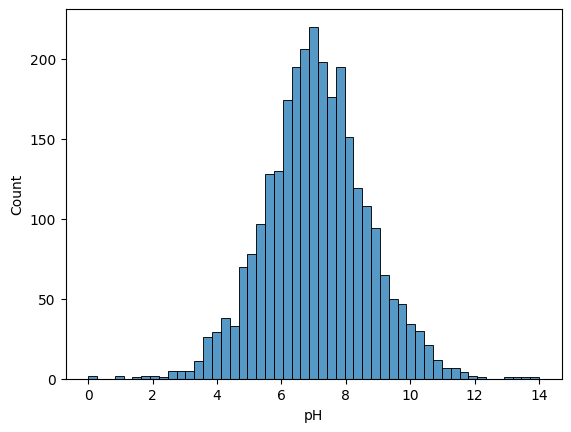

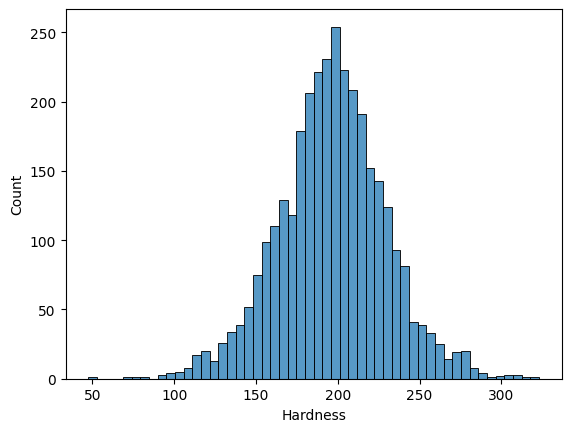

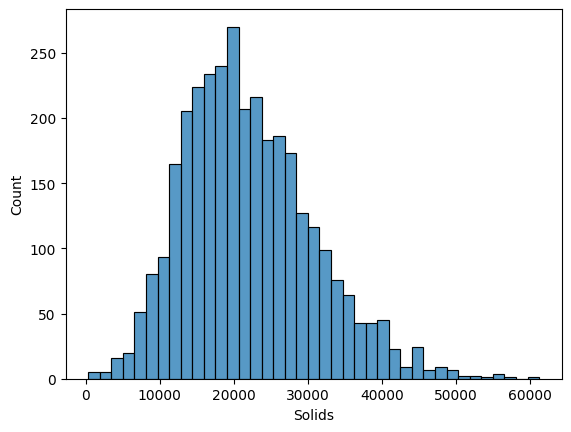

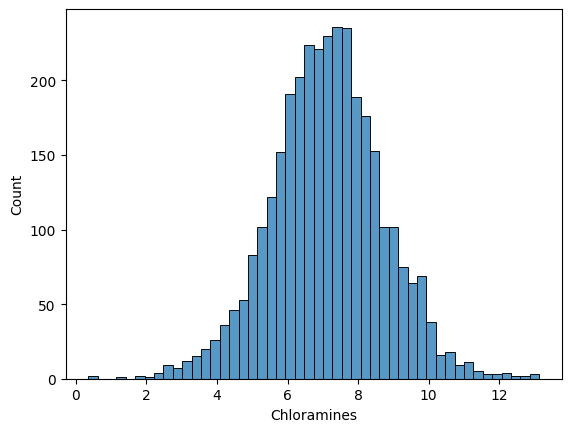

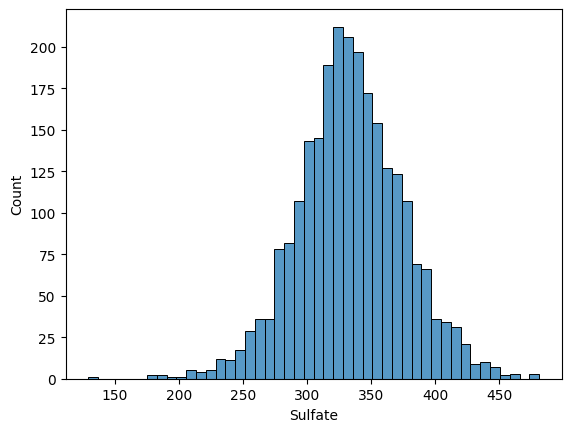

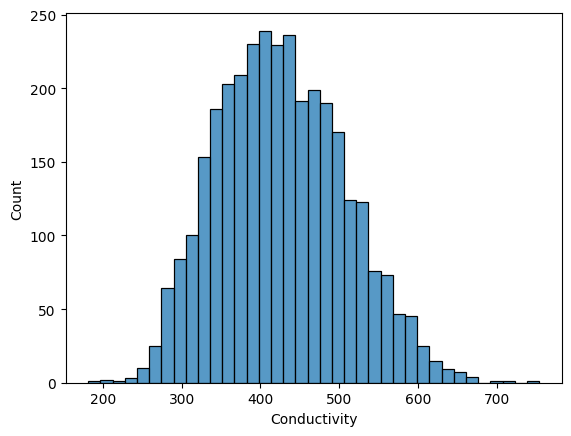

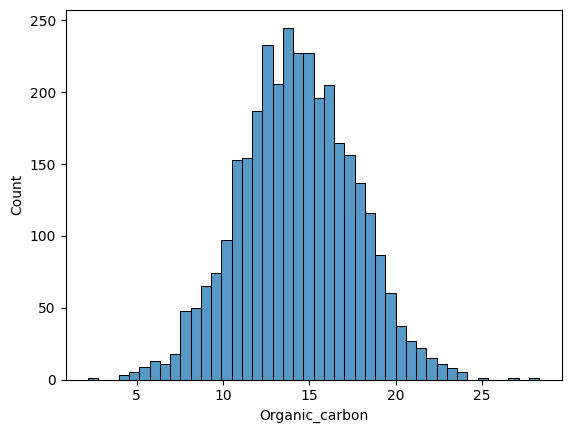

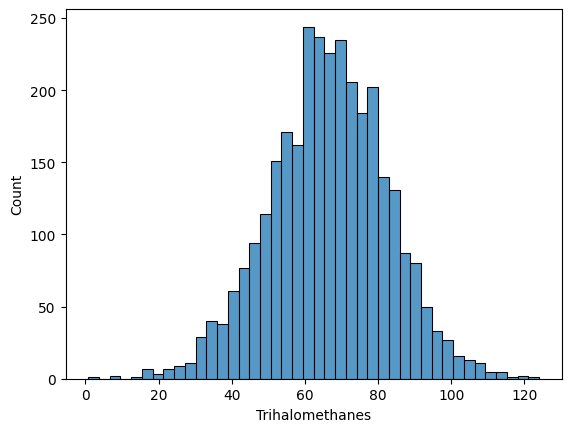

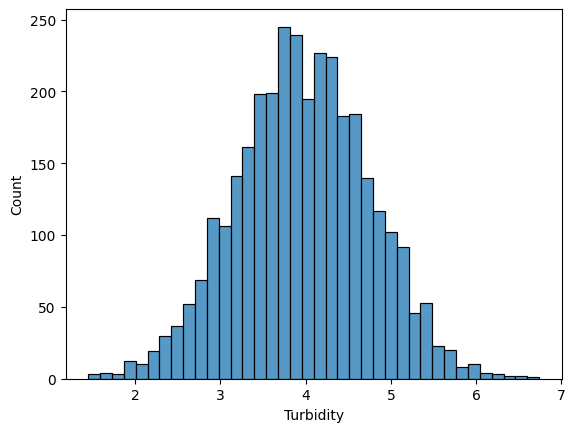

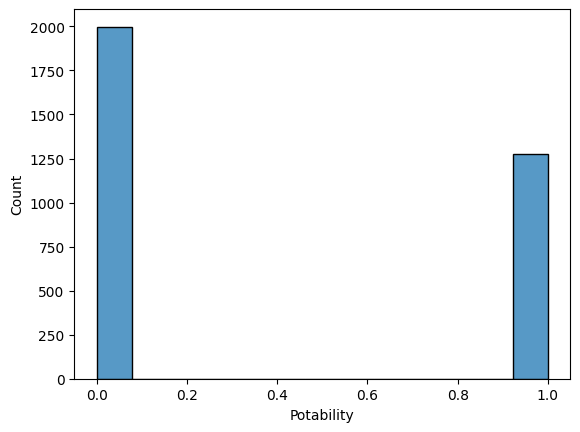

In [11]:
features_tovisualize = features.copy()
for col in features_tovisualize + [target_column]:
    plt.figure()
    sns.histplot(data=df, x=col)

<Axes: ylabel='count'>

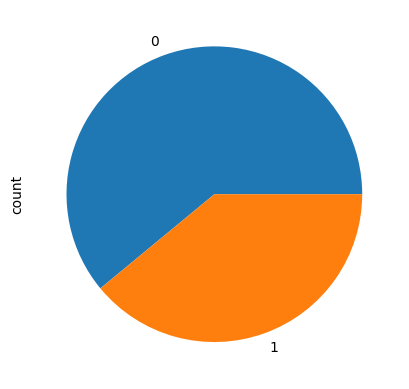

In [12]:
df.Potability.value_counts().plot(kind ='pie')


In [13]:
# Odnos klasa za Potability u procentima
potability_counts = df['Potability'].value_counts(dropna=False).sort_index()
potability_percent = (potability_counts / len(df) * 100).round(2)
display(pd.DataFrame({
    'count': potability_counts,
    'percent': potability_percent
}))

,count,percent
Potability,,
0,1998,60.99
1,1278,39.01


In [14]:
duplicate_rows = df[df.duplicated()]
print("Duplikati:")
print(duplicate_rows)

Duplikati:
Empty DataFrame
Columns: [pH, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity, Potability]
Index: []


## Pregled tipa feature-a

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pH               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Iz ovog mozemo da zakljucimo da nam nije potrebno konvertovanje tipa feature-a iz kategorickih u numericke vrednosti, tako da taj postupak preskacemo. 

## Matrica korelacije - pregled medjusobne zavisnosti kolona

<Axes: >

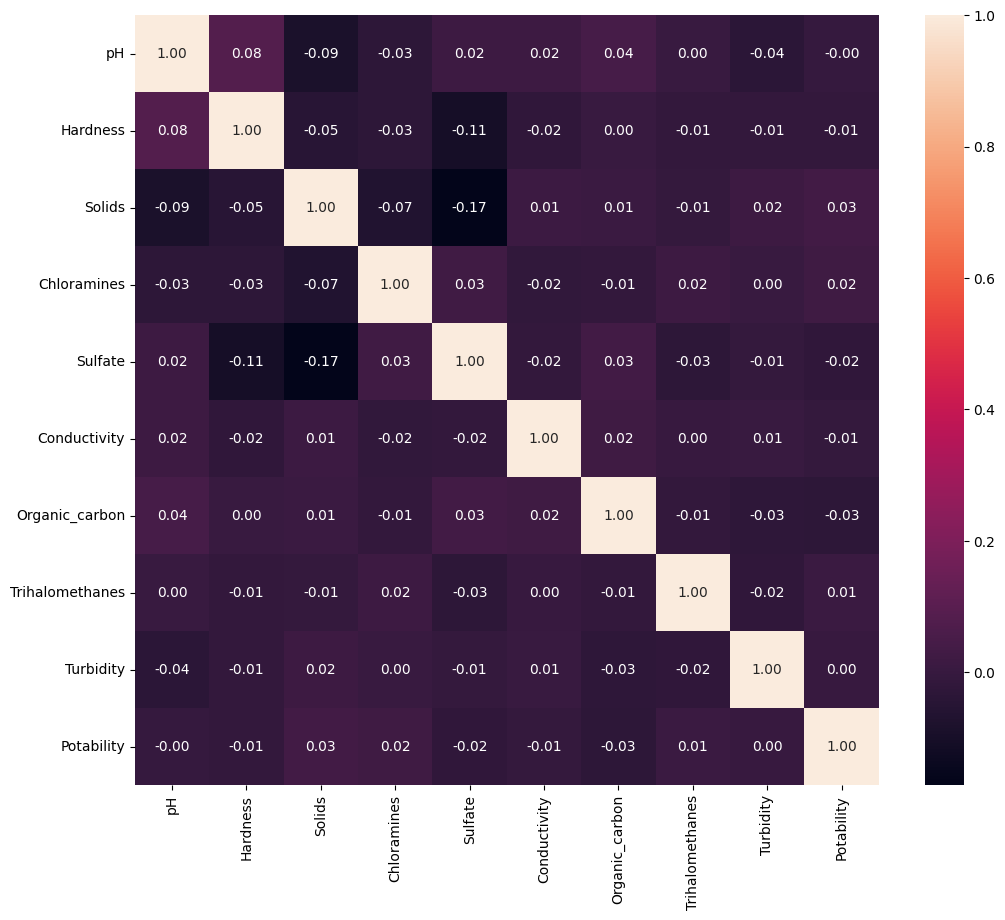

In [16]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

Ovde mozemo da vidimo da nijedna kolona nema preveliku korelacioju s ostalim kolonama, osim kolone Solids za koju smo vec rekli da vidimo malo vece odstupanje u opsegu i prosecnom vrednoscu u zavisnosti od toga da li je voda pitka.

## Analiza nedostajucih vrednosti

In [17]:
df.describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


Ovde vidimo da su vrednosti razlicitog opsega za svaku kolonu, tako da ce najverovatnije biti neophodna normalizacija podataka u kasnijim koracima.

In [18]:
df.isnull().sum()

pH                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Mozemo da vidimo da postoje tri kolone koje imaju null vrednosti, i od toga 2/3 kolone deluju kao da su znacajne za ceo dataset sto mozemo da vidimo kasnije, tako da ce handlovanje nedostajucih vrednosti dosta da utice na preciznost celokupnog dataseta.

In [19]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df[target_column]
)

print("="*70)
print("PODELA PODATAKA NA TRAIN I TEST")
print("="*70)
print(f"Ukupno uzoraka: {len(df)}")
print(f"Train set: {len(df_train)} uzoraka ({len(df_train)/len(df)*100:.1f}%)")
print(f"Test set: {len(df_test)} uzoraka ({len(df_test)/len(df)*100:.1f}%)")
print(f"\nDistribucija klasa u originalnom datasetu:")
print(df[target_column].value_counts())
print(f"\nDistribucija klasa u TRAIN setu:")
print(df_train[target_column].value_counts())
print(f"\nDistribucija klasa u TEST setu:")
print(df_test[target_column].value_counts())
print("="*70)

df = df_train.copy()

PODELA PODATAKA NA TRAIN I TEST
Ukupno uzoraka: 3276
Train set: 2620 uzoraka (80.0%)
Test set: 656 uzoraka (20.0%)

Distribucija klasa u originalnom datasetu:
Potability
0    1998
1    1278
Name: count, dtype: int64

Distribucija klasa u TRAIN setu:
Potability
0    1598
1    1022
Name: count, dtype: int64

Distribucija klasa u TEST setu:
Potability
0    400
1    256
Name: count, dtype: int64


## Baseline Model 

- Pokazuje koliko je problem tezak "sam po sebi"
- Ako nas finalni model nije mnogo bolji od baseline-a, mozda imamo problem sa podacima ili odabranim pristupom
- DummyClassifier simulira "naivne" strategije (nasumicno pogadjanje, uvek predvidja vecinu, itd.)
- Treniramo modele na sirovim podacima (samo brisemo redove sa null vrednostima zato sto kNN i SVM algoritmi ne mogu da rade sa NaN vrednostima)
- Nema preprocesiranja, normalizacije, niti balansiranja klasa
- Ocekujemo relativno lose rezultate koje cemo kasnije poboljsati   

In [20]:

%pip install -q xgboost
%pip install -q lightgbm

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


df_baseline = df.dropna()
print(f"Baseline dataset: {len(df_baseline)} redova (originalno {len(df)}, uklonjeno {len(df) - len(df_baseline)} redova sa NaN)")

X_baseline = df_baseline.drop(columns=[target_column])
y_baseline = df_baseline[target_column]

baseline_models = {
    'MostFrequent': DummyClassifier(strategy='most_frequent'),
    'Stratified': DummyClassifier(strategy='stratified', random_state=42),
    'Uniform': DummyClassifier(strategy='uniform', random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, verbosity=0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
    'LGBMClassifier': LGBMClassifier(random_state=42, verbose=-1),
    'CatBoostClassifier': CatBoostClassifier(random_state=42, verbose=0),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=42)
}

# K-Fold Cross-Validation za baseline
kf_baseline = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nBASELINE REZULTATI sirovi podaci bez obrade")
print("=" * 50)
print("\nDummy klasifikatori")
baseline_results_cv = {}
for name, model in baseline_models.items():
    scores = cross_val_score(model, X_baseline, y_baseline, cv=kf_baseline)
    baseline_results_cv[name] = {
        'mean': scores.mean(),
        'std': scores.std()
    }
    # Razdvoji dummy od pravih modela u ispisu
    if name == 'Uniform':
        print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")
    else:
        print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

best_baseline_name = max(baseline_results_cv, key=lambda x: baseline_results_cv[x]['mean'])
best_baseline_acc = 100*baseline_results_cv[best_baseline_name]['mean']
print(f"\nNajbolji baseline: {best_baseline_name} sa {best_baseline_acc:.2f}% tacnoscu")


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Baseline dataset: 1607 redova (originalno 2620, uklonjeno 1013 redova sa NaN)

BASELINE REZULTATI sirovi podaci bez obrade

Dummy klasifikatori
MostFrequent: 0.5961 (+/- 0.0144)
Stratified: 0.5115 (+/- 0.0289)
Uniform: 0.4978 (+/- 0.0139)
DecisionTree: 0.5875 (+/- 0.0209)
RandomForest: 0.6684 (+/- 0.0244)
XGBoost: 0.6515 (+/- 0.0183)
ExtraTreesClassifier: 0.6758 (+/- 0.0172)


c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036

LGBMClassifier: 0.6503 (+/- 0.0201)
CatBoostClassifier: 0.6833 (+/- 0.0236)
KNN: 0.5619 (+/- 0.0108)
SVM: 0.5961 (+/- 0.0144)

Najbolji baseline: CatBoostClassifier sa 68.33% tacnoscu


Kao sto mozemo da vidimo, tacnost je jako niska. 
Koristili smo DummyClassifier sa vise razlicitih metoda za klasifikaciju dataseta. Dataset nije ni na koji nacin prethodno obradjen, samo sirovi podaci su korisceni sa nebalansiranim, nenormalizovanim datasetom.

In [21]:
df[df['Potability']==0].isnull().sum()

pH                 246
Hardness             0
Solids               0
Chloramines          0
Sulfate            393
Conductivity         0
Organic_carbon       0
Trihalomethanes     90
Turbidity            0
Potability           0
dtype: int64

In [22]:
df[df['Potability']==1].isnull().sum()

pH                 141
Hardness             0
Solids               0
Chloramines          0
Sulfate            232
Conductivity         0
Organic_carbon       0
Trihalomethanes     44
Turbidity            0
Potability           0
dtype: int64

                 count  percent
pH                 387    14.77
Hardness             0     0.00
Solids               0     0.00
Chloramines          0     0.00
Sulfate            625    23.85
Conductivity         0     0.00
Organic_carbon       0     0.00
Trihalomethanes    134     5.11
Turbidity            0     0.00
Potability           0     0.00
Uzoraka sa bar jednim NaN: 1013
Uzoraka bez NaN: 1607


,count,percent
Potability,,
0,640,63.18
1,373,36.82


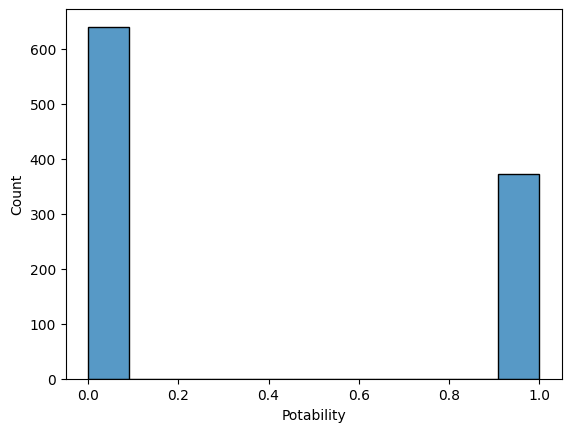

In [23]:
null_counts = df.isnull().sum()
null_percent = (null_counts / len(df) * 100).round(2)
print(pd.DataFrame({
    'count': null_counts,
    'percent': null_percent
}))
only_with_nulls = df[df.isnull().any(axis=1)]
print(f"Uzoraka sa bar jednim NaN: {len(only_with_nulls)}")
plt.figure()
sns.histplot(data=only_with_nulls, x='Potability')

print("Uzoraka bez NaN:", len(df.dropna()))

# Odnos klasa za Potability u procentima
potability_counts = only_with_nulls['Potability'].value_counts(dropna=False).sort_index()
potability_percent = (potability_counts / len(only_with_nulls) * 100).round(2)
display(pd.DataFrame({
    'count': potability_counts,
    'percent': potability_percent
}))

S obzirom da odnos broja redova u odnosu na parametar Pitkost nije pormenila u odnosu na celokupan skup. Mozemo da zakljucimo da su NaN vrednosti skoro isto zastupljene u obe kategorije.

## Brisanje redova koji imaju sve tri prazne kolone 

In [24]:
rows_with_multiple_nulls = df[df.isnull().sum(axis=1) == 3]

print("Redovi sa tri null kolona:")
rows_with_multiple_nulls.describe()

Redovi sa tri null kolona:


,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,0.0,8.000000,8.000000,8.000000,0.0,8.000000,8.000000,0.0,8.000000,8.000000
mean,NaN,193.596073,23018.624407,7.070402,NaN,448.215684,13.707968,NaN,3.805665,0.125000
std,NaN,28.036645,12475.721706,1.333442,NaN,102.469818,2.804555,NaN,0.604967,0.353553
min,NaN,143.300200,11954.700730,4.963124,NaN,293.477998,10.717588,NaN,3.017985,0.000000
25%,NaN,180.591830,15327.148264,6.194290,NaN,380.775344,12.390864,NaN,3.409320,0.000000
50%,NaN,197.585562,18770.863766,7.081072,NaN,451.773737,12.947796,NaN,3.756137,0.000000
75%,NaN,212.553787,25694.204085,7.869322,NaN,539.745090,14.221886,NaN,4.018802,0.000000
max,NaN,226.765646,44982.734155,8.898024,NaN,566.339294,19.585497,NaN,4.863378,1.000000


Vidimo da imamo 9 redova koji imaju te tri kolone sa null vrednostima, tako da brisanje istih nece mnogo da utice na celokupan dataset.

In [25]:
rows_with_multiple_nulls = df[df.isnull().sum(axis=1) >= 2]
print("Redovi sa dve null kolona:")
rows_with_multiple_nulls.describe()


Redovi sa dve null kolona:


,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,27.000000,125.000000,125.000000,125.000000,12.000000,125.000000,125.000000,78.000000,125.000000,125.000000
mean,7.417456,194.366629,21490.661348,7.187526,348.471947,413.569243,14.471145,65.682017,3.936376,0.344000
std,1.709134,30.797061,8798.282924,1.574345,63.989515,72.582267,3.100252,17.190709,0.781069,0.476953
min,4.059431,103.464759,4142.499001,2.750837,234.285621,274.696540,7.070771,18.400012,1.659799,0.000000
25%,6.428889,181.080656,14563.682649,6.362889,318.878290,360.814296,12.167905,56.229357,3.365174,0.000000
50%,7.499845,194.806091,20944.620814,7.317570,338.769303,414.101567,14.134954,67.070220,3.878664,0.000000
75%,8.299979,214.216060,26492.716181,8.272940,386.918311,464.184606,16.657294,75.808563,4.407566,1.000000
max,10.851860,287.370208,44982.734155,11.251507,462.474215,599.614535,22.469892,118.357275,6.204846,1.000000


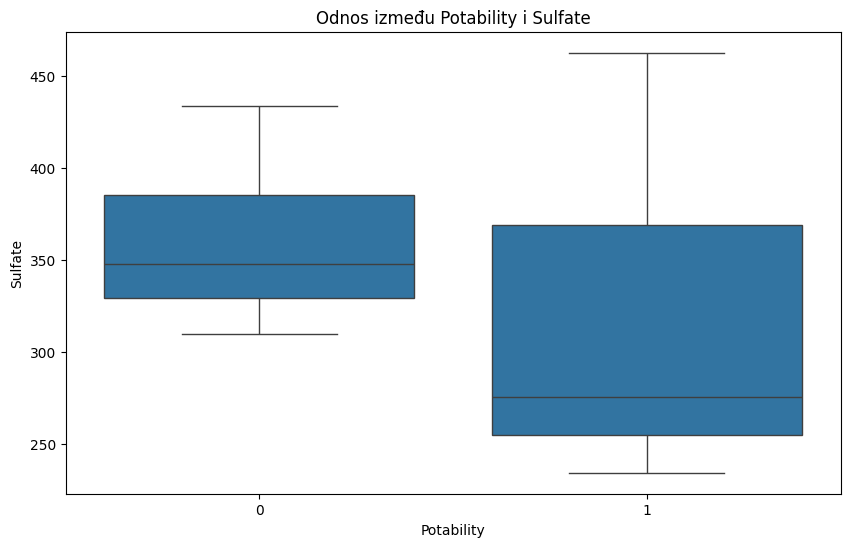

In [26]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=rows_with_multiple_nulls, x='Potability', y='Sulfate')
plt.title('Odnos između Potability i Sulfate')
plt.xlabel('Potability')
plt.ylabel('Sulfate')
plt.show()



In [27]:
# Test different thresholds for removing rows with NaN values
print("=" * 70)
print("POREĐENJE RAZLIČITIH PRAGOVA ZA BRISANJE REDOVA SA NaN")
print("=" * 70)

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score

comparison_results = []

for threshold in [1, 2, 3]:
    # Get rows with >= threshold NaN values
    rows_to_drop = df[df.isnull().sum(axis=1) >= threshold]
    df_filtered = df.drop(rows_to_drop.index)
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    df_filtered_copy = df_filtered.copy()
    df_filtered_copy.iloc[:, :-1] = imputer.fit_transform(df_filtered_copy.iloc[:, :-1])
    
    print(f"\n--- Prag: >= {threshold} NaN vrednosti ---")
    print(f"Redovi izbrisani: {len(rows_to_drop)} ({100*len(rows_to_drop)/len(df):.1f}%)")
    print(f"Preostali redovi: {len(df_filtered)} ({100*len(df_filtered)/len(df):.1f}%)")
    
    X = df_filtered_copy.drop(columns=['Potability'])
    y = df_filtered_copy['Potability']
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    models = {
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
        'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    }
    
    # Define scoring metrics
    scoring_metrics = {
        'Accuracy': 'accuracy',
        'F1': make_scorer(f1_score, zero_division=0),
        'Precision': make_scorer(precision_score, zero_division=0),
        'Recall': make_scorer(recall_score, zero_division=0),
        'ROC-AUC': 'roc_auc'
    }
    
    for model_name, model in models.items():
        # Cross-validation sa svim metrikama
        cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring_metrics, return_train_score=False)
        
        print(f"\n  {model_name}:")
        for metric_name in scoring_metrics.keys():
            scores = cv_results[f'test_{metric_name}']
            print(f"    {metric_name:12} | Mean: {scores.mean():.4f} (+/- {scores.std():.4f})")
            
            comparison_results.append({
                'Prag': threshold,
                'Model': model_name,
                'Metrika': metric_name,
                'Vrednost': scores.mean(),
                'Std': scores.std(),
                'Redova_izbrisano': len(rows_to_drop)
            })

print("\n" + "=" * 70)
comparison_df = pd.DataFrame(comparison_results)
print("\nSUMARNI PRIKAZ - METRIKE:")
print(comparison_df.to_string(index=False))

# Create pivot table for better visualization
print("\n" + "=" * 70)
print("\nPIVOT TABELA - ACCURACY:")
pivot_acc = comparison_df[comparison_df['Metrika'] == 'Accuracy'].pivot_table(
    index='Model', columns='Prag', values='Vrednost', aggfunc='first'
)
print(pivot_acc.round(4))

print("\n" + "=" * 70)
print("\nPIVOT TABELA - F1 SCORE:")
pivot_f1 = comparison_df[comparison_df['Metrika'] == 'F1'].pivot_table(
    index='Model', columns='Prag', values='Vrednost', aggfunc='first'
)
print(pivot_f1.round(4))

POREĐENJE RAZLIČITIH PRAGOVA ZA BRISANJE REDOVA SA NaN

--- Prag: >= 1 NaN vrednosti ---
Redovi izbrisani: 1013 (38.7%)
Preostali redovi: 1607 (61.3%)

  CatBoost:
    Accuracy     | Mean: 0.6764 (+/- 0.0130)
    F1           | Mean: 0.5048 (+/- 0.0319)
    Precision    | Mean: 0.6602 (+/- 0.0229)
    Recall       | Mean: 0.4098 (+/- 0.0384)
    ROC-AUC      | Mean: 0.7150 (+/- 0.0145)

  RandomForest:
    Accuracy     | Mean: 0.6733 (+/- 0.0091)
    F1           | Mean: 0.5045 (+/- 0.0335)
    Precision    | Mean: 0.6518 (+/- 0.0222)
    Recall       | Mean: 0.4145 (+/- 0.0478)
    ROC-AUC      | Mean: 0.6895 (+/- 0.0218)

--- Prag: >= 2 NaN vrednosti ---
Redovi izbrisani: 125 (4.8%)
Preostali redovi: 2495 (95.2%)

  CatBoost:
    Accuracy     | Mean: 0.6830 (+/- 0.0206)
    F1           | Mean: 0.4821 (+/- 0.0311)
    Precision    | Mean: 0.6722 (+/- 0.0490)
    Recall       | Mean: 0.3759 (+/- 0.0227)
    ROC-AUC      | Mean: 0.7054 (+/- 0.0239)

  RandomForest:
    Accuracy     | M

Kada se uporede verdnosti dobijene uklanjenjem redova sa vise od 3 NaN verdnosti, i sa vise od 2 NaN, i basemodel, mozemo da zaklju;imo da najbolji rezultart daje opcija sa uklanjnjem redova sa 3 NaN vrednosti 

In [28]:
# Detaljne tabele za svaku metriku
print("\n" + "=" * 70)
print("DETALJNE TABELE ZA SVE METRIKE")
print("=" * 70)

for metric in ['Accuracy', 'F1', 'Precision', 'Recall', 'ROC-AUC']:
    print(f"\n{'=' * 70}")
    print(f"  {metric.upper()}")
    print(f"{'=' * 80}")
    
    metric_data = comparison_df[comparison_df['Metrika'] == metric].copy()
    metric_data['Vrednost'] = metric_data['Vrednost'].round(4)
    metric_data['Std'] = metric_data['Std'].round(4)
    
    pivot_display = metric_data.pivot_table(
        index='Model',
        columns='Prag',
        values=['Vrednost', 'Std'],
        aggfunc='first'
    )
    
    # Flatten the multi-index columns for better readability
    for prag in [1, 2, 3]:
        print(f"\n  Prag: >= {prag} NaN vrednosti")
        for model in metric_data['Model'].unique():
            data = metric_data[(metric_data['Model'] == model) & (metric_data['Prag'] == prag)]
            if len(data) > 0:
                row = data.iloc[0]
                print(f"    {model:15} | {row['Vrednost']:.4f} ± {row['Std']:.4f}")


DETALJNE TABELE ZA SVE METRIKE

  ACCURACY

  Prag: >= 1 NaN vrednosti
    CatBoost        | 0.6764 ± 0.0130
    RandomForest    | 0.6733 ± 0.0091

  Prag: >= 2 NaN vrednosti
    CatBoost        | 0.6830 ± 0.0206
    RandomForest    | 0.6677 ± 0.0099

  Prag: >= 3 NaN vrednosti
    CatBoost        | 0.6834 ± 0.0126
    RandomForest    | 0.6715 ± 0.0213

  F1

  Prag: >= 1 NaN vrednosti
    CatBoost        | 0.5048 ± 0.0319
    RandomForest    | 0.5045 ± 0.0335

  Prag: >= 2 NaN vrednosti
    CatBoost        | 0.4821 ± 0.0311
    RandomForest    | 0.4506 ± 0.0076

  Prag: >= 3 NaN vrednosti
    CatBoost        | 0.4773 ± 0.0225
    RandomForest    | 0.4476 ± 0.0385

  PRECISION

  Prag: >= 1 NaN vrednosti
    CatBoost        | 0.6602 ± 0.0229
    RandomForest    | 0.6518 ± 0.0222

  Prag: >= 2 NaN vrednosti
    CatBoost        | 0.6722 ± 0.0490
    RandomForest    | 0.6437 ± 0.0317

  Prag: >= 3 NaN vrednosti
    CatBoost        | 0.6738 ± 0.0321
    RandomForest    | 0.6528 ± 0.0506



In [29]:

rows_with_multiple_nulls = df[df.isnull().sum(axis=1) == 3]

In [30]:
df.isnull().sum()

pH                 387
Hardness             0
Solids               0
Chloramines          0
Sulfate            625
Conductivity         0
Organic_carbon       0
Trihalomethanes    134
Turbidity            0
Potability           0
dtype: int64

## Imputiranje praznih vrednosti 

### Metoda imputacije: Mean po grupama (Group Mean Imputation)

U nasem slucaju, hemijske karakteristike vode se razlikuju u zavisnosti od toga da li je voda pitka ili ne. Na primer, pitka voda ima drugaciji prosecni pH od nepitke. Zato grupno imputiranje (po Potability klasi) bolje cuva prirodnu strukturu podataka.
Ova metoda se kasnije pokazala kao najefektivnija za preciznost modela.

In [31]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans

# Ucitaj sirove podatke (sa NaN vrednostima)
df_raw = df.copy()

# Grupna mean imputacija (po Potability)
df_group = df_raw.copy()
for col in ['pH', 'Sulfate', 'Trihalomethanes']:
    df_group[col] = df_group[col].fillna(df_group.groupby('Potability')[col].transform('mean'))


# Grupna mean imputacija (po Potability)
df_ziro = df_raw.copy()
for col in ['pH', 'Sulfate', 'Trihalomethanes']:
    df_ziro[col] = df_ziro[col].fillna(0)

# KNN imputacija
df_knn = df_raw.copy()
imputer_knn = KNNImputer(n_neighbors=5)
df_knn[df_knn.columns[:-1]] = imputer_knn.fit_transform(df_knn[df_knn.columns[:-1]])
# Iterative Imputer (MICE)

df_mice = df_raw.copy()
imputer_mice = IterativeImputer(random_state=42, max_iter=10)
df_mice[df_mice.columns[:-1]] = imputer_mice.fit_transform(df_mice[df_mice.columns[:-1]])

# KMeans clustering-based imputation

df_kmeans = df_raw.copy()
# Separate features with and without NaN
cols_with_nan = ['pH', 'Sulfate', 'Trihalomethanes']
cols_without_nan = [col for col in df_kmeans.columns[:-1] if col not in cols_with_nan]

# Fit KMeans on complete features
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_complete = df_kmeans[cols_without_nan].values
clusters = kmeans.fit_predict(df_complete)
df_kmeans['cluster'] = clusters

# Impute missing values with cluster mean
for col in cols_with_nan:
    df_kmeans[col] = df_kmeans.groupby('cluster')[col].transform(
        lambda x: x.fillna(x.mean())
    )

df_kmeans = df_kmeans.drop(columns=['cluster'])

# Uporedna evaluacija
clear_preprocessing_results()
print("=== Grupna mean imputacija ===")
evaluate_models_after_step(df_group, "Imputacija: Group Mean", compare_scalers=False)

print("\n=== Grupna zero imputacija ===")
evaluate_models_after_step(df_ziro, "Imputacija: Group Zero", compare_scalers=False)

print("\n=== KNN imputacija ===")
evaluate_models_after_step(df_knn, "Imputacija: KNN", compare_scalers=False)

print("\n=== MICE imputacija ===")
evaluate_models_after_step(df_mice, "Imputacija: MICE", compare_scalers=False)

print("\n=== KMeans clustering-based imputacija ===")
evaluate_models_after_step(df_kmeans, "Imputacija: KMeans", compare_scalers=False)

=== Grupna mean imputacija ===

EVALUACIJA: Imputacija: Group Mean
Dataset: 2620 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1598), 1: np.int64(1022)}
  DecisionTree       | Accuracy: 0.7344 (+/- 0.0109)
  RandomForest       | Accuracy: 0.7885 (+/- 0.0168)
  ExtraTrees         | Accuracy: 0.6943 (+/- 0.0076)
  XGBoost            | Accuracy: 0.7782 (+/- 0.0098)
  LightGBM           | Accuracy: 0.7786 (+/- 0.0119)
  CatBoost           | Accuracy: 0.8031 (+/- 0.0104)
  KNN                | Accuracy: 0.6340 (+/- 0.0164)
  SVM                | Accuracy: 0.6798 (+/- 0.0101)

  NAJBOLJI: CatBoost (0.8031)
Step             Imputacija: Group Mean
Model                          CatBoost
Accuracy_Mean                  0.803053
Accuracy_Std                   0.010411
F1                             0.712664
Recall                         0.626198
Precision                      0.827166
Name: 5, dtype: object

=== Grupna zero imputacija ===

EVALUACIJA: Imputacija: Group Zero
Dataset: 2620 u

,Step,Model,Accuracy_Mean,Accuracy_Std,F1,Recall,Precision
0,Imputacija: KMeans,DecisionTree,0.593130,0.014045,0.489125,0.500019,0.480149
1,Imputacija: KMeans,RandomForest,0.671374,0.009686,0.454318,0.352209,0.645749
2,Imputacija: KMeans,ExtraTrees,0.668321,0.009380,0.424808,0.315983,0.654760
3,Imputacija: KMeans,XGBoost,0.648092,0.013846,0.497747,0.447169,0.563128
4,Imputacija: KMeans,LightGBM,0.648473,0.018518,0.470157,0.403118,0.569317
5,Imputacija: KMeans,CatBoost,0.676718,0.007595,0.465732,0.363945,0.654669
6,Imputacija: KMeans,KNN,0.633969,0.017755,0.460264,0.400143,0.542157
7,Imputacija: KMeans,SVM,0.685878,0.010069,0.429369,0.304319,0.735364


In [32]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

df_group_m = df.copy()
df_group_m = pd.DataFrame(
    imputer.fit_transform(df_group_m),
    columns=df.columns
)
    
clear_preprocessing_results()
print("=== Grupna median imputacija ===")
evaluate_models_after_step(df_group_m, "Imputacija: Group Median", compare_scalers=False)

=== Grupna median imputacija ===

EVALUACIJA: Imputacija: Group Median
Dataset: 2620 uzoraka, 9 osobina
Distribucija klasa: {0.0: np.int64(1598), 1.0: np.int64(1022)}
  DecisionTree       | Accuracy: 0.5947 (+/- 0.0155)
  RandomForest       | Accuracy: 0.6744 (+/- 0.0101)
  ExtraTrees         | Accuracy: 0.6760 (+/- 0.0090)
  XGBoost            | Accuracy: 0.6363 (+/- 0.0149)
  LightGBM           | Accuracy: 0.6531 (+/- 0.0079)
  CatBoost           | Accuracy: 0.6790 (+/- 0.0139)
  KNN                | Accuracy: 0.6340 (+/- 0.0191)
  SVM                | Accuracy: 0.6802 (+/- 0.0106)

  NAJBOLJI: SVM (0.6802)
Step             Imputacija: Group Median
Model                                 SVM
Accuracy_Mean                    0.680153
Accuracy_Std                     0.010632
F1                               0.416323
Recall                           0.293549
Precision                        0.721035
Name: 7, dtype: object


,Step,Model,Accuracy_Mean,Accuracy_Std,F1,Recall,Precision
0,Imputacija: Group Median,DecisionTree,0.594656,0.015485,0.502246,0.525375,0.482358
1,Imputacija: Group Median,RandomForest,0.674427,0.010141,0.458106,0.353228,0.654648
2,Imputacija: Group Median,ExtraTrees,0.675954,0.008984,0.432584,0.317963,0.681573
3,Imputacija: Group Median,XGBoost,0.636260,0.014861,0.477558,0.427551,0.545413
4,Imputacija: Group Median,LightGBM,0.653053,0.007859,0.483171,0.416820,0.577026
5,Imputacija: Group Median,CatBoost,0.679008,0.013940,0.461720,0.354151,0.666309
6,Imputacija: Group Median,KNN,0.633969,0.019061,0.462086,0.403080,0.541744
7,Imputacija: Group Median,SVM,0.680153,0.010632,0.416323,0.293549,0.721035


In [33]:
df['pH']=df['pH'].fillna(df.groupby(['Potability'])['pH'].transform('mean'))
df['Sulfate']=df['Sulfate'].fillna(df.groupby(['Potability'])['Sulfate'].transform('mean'))

# Procenat nedostajajucih vrednosti je oko 5%
#df_imputed = df.copy()
df['Trihalomethanes']=df['Trihalomethanes'].fillna(df.groupby(['Potability'])['Trihalomethanes'].transform('mean'))

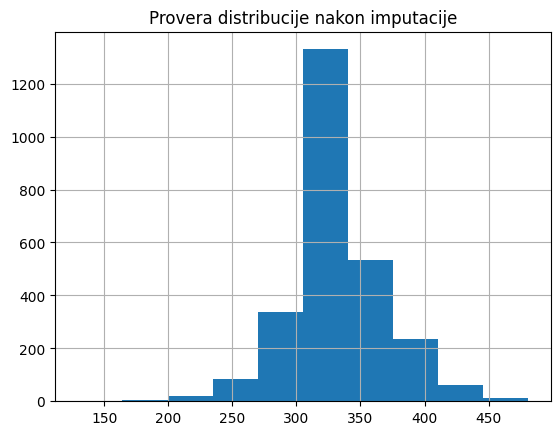

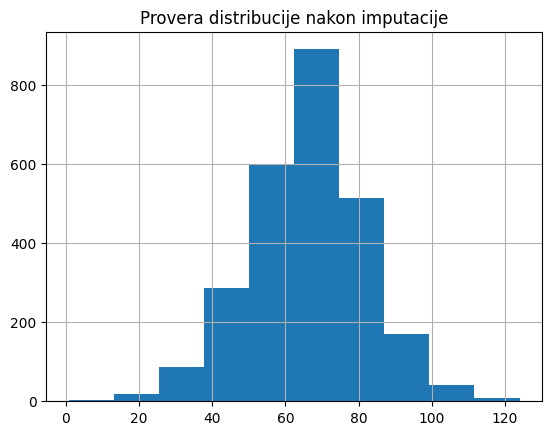

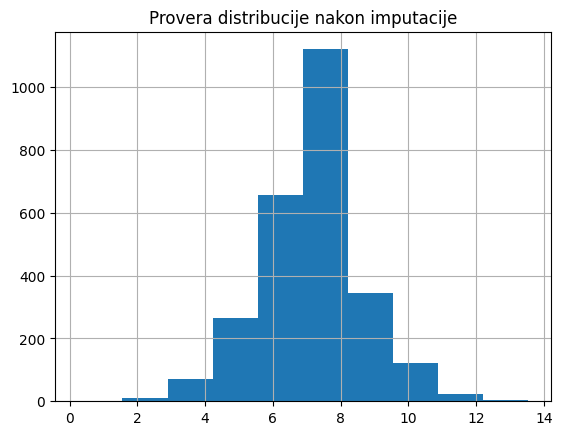

In [34]:
import matplotlib.pyplot as plt

for col in ['Sulfate', 'Trihalomethanes', 'pH']:
    df[col].hist()
    plt.title("Provera distribucije nakon imputacije")
    plt.show()

In [35]:
clear_preprocessing_results()
evaluate_models_after_step(df, "2. Nakon imputacije", compare_scalers=False)


EVALUACIJA: 2. Nakon imputacije
Dataset: 2620 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1598), 1: np.int64(1022)}
  DecisionTree       | Accuracy: 0.7344 (+/- 0.0109)
  RandomForest       | Accuracy: 0.7885 (+/- 0.0168)
  ExtraTrees         | Accuracy: 0.6943 (+/- 0.0076)
  XGBoost            | Accuracy: 0.7782 (+/- 0.0098)
  LightGBM           | Accuracy: 0.7786 (+/- 0.0119)
  CatBoost           | Accuracy: 0.8031 (+/- 0.0104)
  KNN                | Accuracy: 0.6340 (+/- 0.0164)
  SVM                | Accuracy: 0.6798 (+/- 0.0101)

  NAJBOLJI: CatBoost (0.8031)
Step             2. Nakon imputacije
Model                       CatBoost
Accuracy_Mean               0.803053
Accuracy_Std                0.010411
F1                          0.712664
Recall                      0.626198
Precision                   0.827166
Name: 5, dtype: object


,Step,Model,Accuracy_Mean,Accuracy_Std,F1,Recall,Precision
0,2. Nakon imputacije,DecisionTree,0.734351,0.010890,0.662505,0.668274,0.657122
1,2. Nakon imputacije,RandomForest,0.788550,0.016829,0.693534,0.613458,0.798450
2,2. Nakon imputacije,ExtraTrees,0.694275,0.007576,0.477446,0.359087,0.716395
3,2. Nakon imputacije,XGBoost,0.778244,0.009761,0.694185,0.645763,0.750743
4,2. Nakon imputacije,LightGBM,0.778626,0.011948,0.693884,0.643812,0.752737
5,2. Nakon imputacije,CatBoost,0.803053,0.010411,0.712664,0.626198,0.827166
6,2. Nakon imputacije,KNN,0.633969,0.016434,0.460924,0.401129,0.541971
7,2. Nakon imputacije,SVM,0.679771,0.010055,0.416830,0.294529,0.718878


In [36]:
df.isnull().sum()

pH                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

Kao sto vidimo, vrednosti su uspesno popunjene i vise nemamo praznih kolona. Sada mozemo da vidimo kako izgledaju podaci u zavisnosti od ciljne kolone - Potability.

In [37]:
df[df['Potability']==0].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.0
mean,7.074201,196.580900,21694.555519,7.093951,334.488840,427.745106,14.307148,66.088394,3.972854,0.0
std,1.540679,30.631578,8512.756916,1.522830,31.830496,79.859995,3.303359,15.564270,0.782261,0.0
min,1.431782,98.452931,320.942611,1.683993,203.444521,181.483754,4.371899,0.738000,1.496101,0.0
25%,6.207579,178.070023,15564.602638,6.163502,319.266920,369.019803,12.056463,56.348396,3.441490,0.0
50%,7.074201,196.595414,20717.105061,7.103511,334.488840,424.471302,14.215791,66.088394,3.975469,0.0
75%,7.917875,215.566226,26886.952103,8.076312,347.608480,481.833045,16.567271,76.266285,4.491256,0.0
max,13.541240,300.292476,61227.196008,12.653362,460.107069,753.342620,27.006707,120.030077,6.739000,0.0


In [38]:
df[df['Potability']==1].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.0
mean,7.108528,196.426897,22190.643624,7.151405,333.223613,428.182833,14.218926,66.226473,3.975234,1.0
std,1.351742,35.563773,9129.471269,1.712026,42.216833,82.648663,3.286784,16.156359,0.777713,0.0
min,0.227499,47.432000,728.750830,0.352000,129.000000,217.358330,2.200000,8.175876,1.492207,1.0
25%,6.395387,175.432245,15465.363183,6.052034,314.440590,365.514835,12.055264,56.060032,3.435146,1.0
50%,7.108528,197.542202,21150.782366,7.144995,333.223613,425.517867,14.202889,66.226473,3.966126,1.0
75%,7.807736,217.784278,27468.905554,8.173243,355.179478,489.517439,16.502383,76.610799,4.498631,1.0
max,13.175402,323.124000,56488.672413,13.043806,481.030642,695.369528,23.604298,124.000000,6.226580,1.0


In [39]:
df.groupby('Potability').median().T

Potability,0,1
pH,7.074201,7.108528
Hardness,196.595414,197.542202
Solids,20717.105061,21150.782366
Chloramines,7.103511,7.144995
Sulfate,334.488840,333.223613
Conductivity,424.471302,425.517867
Organic_carbon,14.215791,14.202889
Trihalomethanes,66.088394,66.226473
Turbidity,3.975469,3.966126


In [40]:
df.groupby('Potability').mean().T

Potability,0,1
pH,7.074201,7.108528
Hardness,196.580900,196.426897
Solids,21694.555519,22190.643624
Chloramines,7.093951,7.151405
Sulfate,334.488840,333.223613
Conductivity,427.745106,428.182833
Organic_carbon,14.307148,14.218926
Trihalomethanes,66.088394,66.226473
Turbidity,3.972854,3.975234


Iz ovih podataka mozemo da uocimo da dataset nije balansiran, postoje vise slogova gde je voda oznacena kao nepitka, a i sam raspon vrednosti se razlikuje, pogotovo za kolonu Solids i Hardness. Sada mozemo da kreiramo i matricu korelacije da vidimo koja je medjusobna zavinost svih tih kolona:

<Axes: >

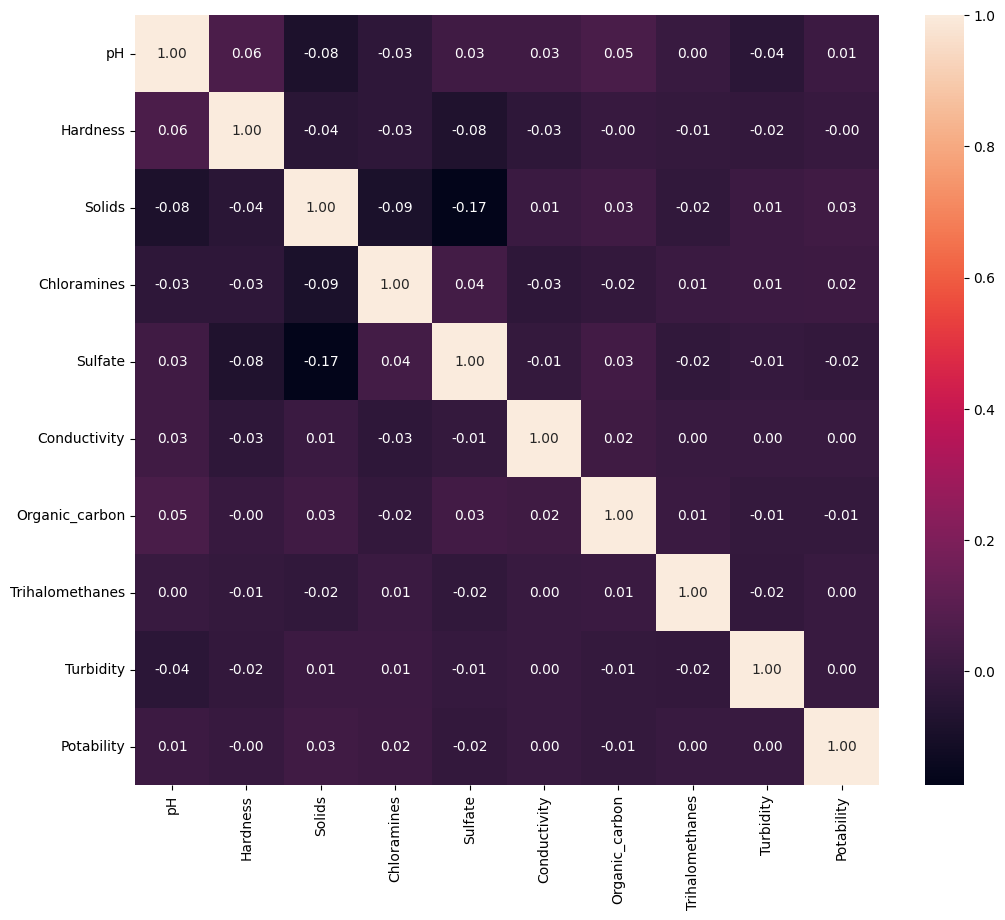

In [41]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

Nakon izvrsenog imputiranja praznih vrednosti, vidimo da se korelacija u krajnjem slucaju jos vise smanjila, sto je mozda i ocekivano.

Izvucicemo sve feature-e da bismo lakse izvukli šumove po svakoj koloni:

In [42]:
numerical_features = df.columns.tolist()

### Metode detekcije outliera

| Metoda | Formula | Prag | Osetljivost | Tipican procenat outliera (normalna distribucija) |
|--------|---------|------|-------------|----------------------------------------------------|
| **Z-score** | (x - mean) / std | |z| > 3 | Niska (3 std od proseka) | ~0.27% |
| **IQR** | Q1 - 1.5*IQR, Q3 + 1.5*IQR | Van opsega | Visoka | ~4.3% |
| **Mod Z-score** | 0.6745(xi – x̃) / MAD | -3.5 > x > 3.5 | Srednja | ~0.05% |

- Vazno jer imamo relativno mali dataset (~3000 uzoraka) i ne mozemo sebi dozvoliti da izgubimo previse podataka
- RandomForest i ostali tree-based modeli su otporni na outliere, ali brisanje outliera i dalje moze da promeni ishod tacnosti modela

In [43]:
def outliers_iqr(x: pd.Series):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((x > upper_bound) | (x < lower_bound))[0]

def outliers_z_score(ys: pd.Series):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

def outliers_modified_z_score(ys: pd.Series):
    threshold = 3.5

    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    
    if median_absolute_deviation_y == 0:
        median_absolute_deviation_y = np.finfo(np.double).min
    
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)[0]


outliers = {}
print("Outliers:",' ' * 26,"IQR ZScore ModZScore")
for col in numerical_features:
    outliersIQR = outliers_iqr(df[col])
    outliersZScore = outliers_z_score(df[col])
    outliersModZScore = outliers_modified_z_score(df[col])
    outliers[col] = (outliersIQR, outliersZScore, outliersModZScore)
    print(f"Column '{col:24}': {len(outliersIQR):5} {len(outliersZScore):6} {len(outliersModZScore):9}")
print()



Outliers:                            IQR ZScore ModZScore
Column 'pH                      ':   115     19        30
Column 'Hardness                ':    73     16        12
Column 'Solids                  ':    36     17         9
Column 'Chloramines             ':    53     16         8
Column 'Sulfate                 ':   225     28        96
Column 'Conductivity            ':     7      5         1
Column 'Organic_carbon          ':    20      3         2
Column 'Trihalomethanes         ':    47     14         5
Column 'Turbidity               ':    14      5         1
Column 'Potability              ':     0      0         0



Od tri metode koje smo iskoristili, Z-score je "najmanje osetljiv" na sumove sto nam odgovara, jer ne smemo da brisemo previse redova zbog manjka podataka s kojim raspolazemo.

In [44]:
z_scores = np.abs((df - df.mean()) / df.std())

# threshold for Z-scores
threshold = 3
outliers = (z_scores > threshold).any(axis=1)
# remove outliers
df_no_outliers = df[~outliers]


In [45]:
# Evaluate models after outlier removal
clear_preprocessing_results()
results_df = evaluate_models_after_step(df_no_outliers, "2. Bez outliera", compare_scalers=False)


EVALUACIJA: 2. Bez outliera
Dataset: 2503 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1543), 1: np.int64(960)}
  DecisionTree       | Accuracy: 0.7175 (+/- 0.0160)
  RandomForest       | Accuracy: 0.7830 (+/- 0.0150)
  ExtraTrees         | Accuracy: 0.6884 (+/- 0.0132)
  XGBoost            | Accuracy: 0.7787 (+/- 0.0095)
  LightGBM           | Accuracy: 0.7871 (+/- 0.0093)
  CatBoost           | Accuracy: 0.8010 (+/- 0.0183)
  KNN                | Accuracy: 0.6352 (+/- 0.0125)
  SVM                | Accuracy: 0.6856 (+/- 0.0105)

  NAJBOLJI: CatBoost (0.8010)
Step             2. Bez outliera
Model                   CatBoost
Accuracy_Mean           0.801028
Accuracy_Std             0.01828
F1                      0.706207
Recall                  0.623958
Precision               0.815315
Name: 5, dtype: object


In [46]:
# Apply Modified Z-Score outlier detection and removal on df
def outliers_modified_z_score(ys: pd.Series):
    threshold = 3.5
    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    
    if median_absolute_deviation_y == 0:
        median_absolute_deviation_y = np.finfo(np.double).min
    
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)[0]

# Detect outliers in each feature
all_outlier_indices = set()
for col in df.columns[:-1]:  # Exclude Potability column
    outlier_indices = outliers_modified_z_score(df[col])
    all_outlier_indices.update(outlier_indices)

# Convert to sorted list for dropping
outlier_indices_to_drop = sorted(list(all_outlier_indices))

print(f"Ukupno detektovanih outliera: {len(outlier_indices_to_drop)}")
print(f"Originalni broj redova: {len(df)}")

# Remove outliers
df_zmod = df.copy()
df_zmod = df_zmod.drop(df_zmod.index[outlier_indices_to_drop])

print(f"Novi broj redova nakon uklanjanja outliera: {len(df_zmod)}")
print(f"Uklonjeno redova: {len(outlier_indices_to_drop)} ({100*len(outlier_indices_to_drop)/len(df_zmod):.2f}%)")

# Evaluate models after outlier removal with Modified Z-Score
clear_preprocessing_results()
evaluate_models_after_step(df_zmod, "3. Bez outliera (Modified Z-Score)", compare_scalers=False)

Ukupno detektovanih outliera: 153
Originalni broj redova: 2620
Novi broj redova nakon uklanjanja outliera: 2467
Uklonjeno redova: 153 (6.20%)

EVALUACIJA: 3. Bez outliera (Modified Z-Score)
Dataset: 2467 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1535), 1: np.int64(932)}
  DecisionTree       | Accuracy: 0.7260 (+/- 0.0211)
  RandomForest       | Accuracy: 0.7831 (+/- 0.0141)
  ExtraTrees         | Accuracy: 0.6879 (+/- 0.0096)
  XGBoost            | Accuracy: 0.7823 (+/- 0.0104)
  LightGBM           | Accuracy: 0.7835 (+/- 0.0084)
  CatBoost           | Accuracy: 0.7985 (+/- 0.0066)
  KNN                | Accuracy: 0.6234 (+/- 0.0208)
  SVM                | Accuracy: 0.6713 (+/- 0.0069)

  NAJBOLJI: CatBoost (0.7985)
Step             3. Bez outliera (Modified Z-Score)
Model                                      CatBoost
Accuracy_Mean                              0.798538
Accuracy_Std                               0.006564
F1                                         0.691494
Reca

,Step,Model,Accuracy_Mean,Accuracy_Std,F1,Recall,Precision
0,3. Bez outliera (Modified Z-Score),DecisionTree,0.725991,0.021085,0.640642,0.645897,0.636295
1,3. Bez outliera (Modified Z-Score),RandomForest,0.783136,0.014127,0.669168,0.580473,0.791352
2,3. Bez outliera (Modified Z-Score),ExtraTrees,0.687888,0.009581,0.428236,0.310149,0.693828
3,3. Bez outliera (Modified Z-Score),XGBoost,0.782322,0.010410,0.689372,0.639469,0.747960
4,3. Bez outliera (Modified Z-Score),LightGBM,0.783539,0.008353,0.687761,0.630924,0.756689
5,3. Bez outliera (Modified Z-Score),CatBoost,0.798538,0.006564,0.691494,0.597654,0.821861
6,3. Bez outliera (Modified Z-Score),KNN,0.623436,0.020771,0.427655,0.373452,0.501377
7,3. Bez outliera (Modified Z-Score),SVM,0.671266,0.006939,0.363636,0.248951,0.678099


In [47]:
df = df_no_outliers.copy()

### Zakljucak nakon brisanja outliera
Kao sto vidimo, tacnost modela nam se pogorsala nakon sto smo obrisali outliere, sto je i ocekivano, jer najmanja promena u broju podataka moze da napravi jak efekat na tacnost modela zbog malog broja podataka. Stoga, zadrzacemo sve outliere kako bismo odrzali sto vecu tacnost.

## Balansiranje klasa (Resampling)

Nebalansirane klase su cest problem u klasifikaciji. U nasem datasetu imamo vise nepitke vode (~60%) nego pitke (~40%). Ovo moze navesti model da "favorizuje" vecinu klasu.

**Vazno:** Balansiranje se mora raditi **samo na train setu** da bi se izbeglo curenje podataka (data leakage). Ako radimo upsampling na celom datasetu pre split-a, isti (duplirani) podaci mogu zavrsiti i u train i u test setu, sto daje lazno optimisticne rezultate.

Poredimo dve tehnike:
- **Upsampling**: Dupliramo uzorke manjinske klase da bismo dobili vise podataka za trening
- **Downsampling**: Smanjujemo uzorke vecinske klase da bismo imali balansirane klase
**Tehnike balansiranja:**
- **SMOTE (Synthetic Minority Over-sampling Technique)**: Kreira sinteticke uzorke manjinske klase interpolacijom izmedju postojecih uzoraka
- **Random Undersampling**: Nasumicno brise uzorke vecinske klase
- **Random Oversampling**: Duplira postojece uzorke manjinske klase

**Napomena:** U cell 72 ispod se evaluiraju sve tri metode plus baseline (bez balansiranja) sa svim metrikama (Accuracy, F1, Precision, Recall, AUC) da bi se utvrdilo koja metoda daje najbolje rezultate na ovom konkretnom datasetu.

In [48]:
# Balansiranje klasa - poređenje svih metoda sa SVIM METRIKAMA
%pip install imblearn

from sklearn.utils import resample, shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

def balance_train_data(X_train, y_train, method='upsample', random_state=42):
    """
    Balansira train podatke koristeci upsampling, downsampling ili SMOTE.
    """
    if method == 'none':
        return X_train, y_train

    if method == 'smote':
        smote = SMOTE(random_state=random_state)
        X_balanced, y_balanced = smote.fit_resample(X_train, y_train)
        return X_balanced, y_balanced

    train_data = pd.DataFrame(X_train.copy())
    train_data['target'] = y_train

    class_0 = train_data[train_data['target'] == 0]
    class_1 = train_data[train_data['target'] == 1]

    if method == 'upsample':
        n_samples = max(len(class_0), len(class_1))
        if len(class_0) < len(class_1):
            class_0 = resample(class_0, replace=True, n_samples=n_samples, random_state=random_state)
        else:
            class_1 = resample(class_1, replace=True, n_samples=n_samples, random_state=random_state)
    else:  # downsample
        n_samples = min(len(class_0), len(class_1))
        if len(class_0) > len(class_1):
            class_0 = resample(class_0, replace=False, n_samples=n_samples, random_state=random_state)
        else:
            class_1 = resample(class_1, replace=False, n_samples=n_samples, random_state=random_state)

    balanced_data = pd.concat([class_0, class_1])
    balanced_data = shuffle(balanced_data, random_state=random_state)

    X_balanced = balanced_data.drop('target', axis=1).values
    y_balanced = balanced_data['target'].values

    return X_balanced, y_balanced

def evaluate_all_metrics(df_data, method='none', target_col='Potability', k=5):

    X = df_data.drop(columns=[target_col]).values
    y = df_data[target_col].values

    models = {
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=42, verbosity=0, n_jobs=-1),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    }

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'recall': [], 'auc': []}
               for name in models.keys()}

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        X_train_balanced, y_train_balanced = balance_train_data(X_train, y_train, method=method, random_state=42+fold)

        for name, model in models.items():
            from sklearn.base import clone
            model_clone = clone(model)
            model_clone.fit(X_train_balanced, y_train_balanced)

            y_pred = model_clone.predict(X_test)
            y_proba = model_clone.predict_proba(X_test)[:, 1]

            results[name]['accuracy'].append(accuracy_score(y_test, y_pred))
            results[name]['f1'].append(f1_score(y_test, y_pred))
            results[name]['precision'].append(precision_score(y_test, y_pred))
            results[name]['recall'].append(recall_score(y_test, y_pred))
            results[name]['auc'].append(roc_auc_score(y_test, y_proba))

    summary = []
    for name, metrics in results.items():
        summary.append({
            'Model': name,
            'Accuracy': np.mean(metrics['accuracy']),
            'F1': np.mean(metrics['f1']),
            'Precision': np.mean(metrics['precision']),
            'Recall': np.mean(metrics['recall']),
            'AUC': np.mean(metrics['auc'])
        })

    return pd.DataFrame(summary)

# Distribucija klasa
print("Distribucija klasa:")
print(df['Potability'].value_counts())
print(f"Odnos: {df['Potability'].value_counts()[0]/len(df)*100:.1f}% / {df['Potability'].value_counts()[1]/len(df)*100:.1f}%")

# Evaluacija svih metoda
methods = {
    'BEZ BALANSIRANJA': 'none',
    'UPSAMPLING': 'upsample',
    'DOWNSAMPLING': 'downsample',
    'SMOTE': 'smote'
}

all_results = {}
for name, method in methods.items():
    print(f"\nEvaluacija: {name}...")
    all_results[name] = evaluate_all_metrics(df, method=method, k=5)

# Prikaz rezultata za svaku metodu
for name, results_df in all_results.items():
    print()
    print("=" * 85)
    print(f"{name}")
    print("=" * 85)
    print(results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# UPOREDNA TABELA - prosek svih modela po metodi
print()
print("=" * 85)
print("PROSECNE METRIKE PO METODI BALANSIRANJA (prosek svih modela)")
print("=" * 85)

comparison_data = []
for name, results_df in all_results.items():
    comparison_data.append({
        'Metoda': name,
        'Accuracy': results_df['Accuracy'].mean(),
        'F1': results_df['F1'].mean(),
        'Precision': results_df['Precision'].mean(),
        'Recall': results_df['Recall'].mean(),
        'AUC': results_df['AUC'].mean()
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Najbolja metoda po svakoj metrici
print()
print("=" * 85)
print("NAJBOLJA METODA PO SVAKOJ METRICI")
print("=" * 85)
for metric in ['Accuracy', 'F1', 'Precision', 'Recall', 'AUC']:
    best_idx = comparison_df[metric].idxmax()
    best_method = comparison_df.loc[best_idx, 'Metoda']
    best_value = comparison_df.loc[best_idx, metric]
    print(f"  {metric:12} -> {best_method:20} ({best_value:.4f})")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Distribucija klasa:
Potability
0    1543
1     960
Name: count, dtype: int64
Odnos: 61.6% / 38.4%

Evaluacija: BEZ BALANSIRANJA...

Evaluacija: UPSAMPLING...

Evaluacija: DOWNSAMPLING...

Evaluacija: SMOTE...

BEZ BALANSIRANJA
       Model  Accuracy     F1  Precision  Recall    AUC
DecisionTree    0.7175 0.6340     0.6295  0.6396 0.7028
RandomForest    0.7830 0.6778     0.7880  0.5958 0.8604
     XGBoost    0.7787 0.6884     0.7477  0.6396 0.8643
    LightGBM    0.7871 0.6979     0.7654  0.6438 0.8679
    CatBoost    0.8010 0.7062     0.8153  0.6240 0.8827

UPSAMPLING
       Model  Accuracy     F1  Precision  Recall    AUC
DecisionTree    0.7295 0.6325     0.6591  0.6094 0.7068
RandomForest    0.7871 0.6808     0.8007  0.5938 0.8577
     XGBoost    0.7747 0.6849     0.7380  0.6396 0.8582
    LightGBM    0.7815 0.6900     0.7571  0.6365 0.8641
    CatBoost    0.7934 0.7115     0.7652  0.6656 0.8794

DOWNSAMPLING
       Model  Accuracy     F1  Precision  Recall    AUC
DecisionTree    0.7

In [49]:
#SMOTE je najbolja metoda balansiranja na ovom skupu podataka!
smote = SMOTE(random_state=42)
X = df.drop(columns=['Potability'])
y = df['Potability']

X_smote, y_smote = smote.fit_resample(X, y)
balanced_data = pd.concat(
    [pd.DataFrame(X_smote, columns=X.columns), pd.Series(y_smote, name='Potability')],
    axis=1
)

print("Posle SMOTE balansiranja:")
print(balanced_data['Potability'].value_counts())

Posle SMOTE balansiranja:
Potability
0    1543
1    1543
Name: count, dtype: int64


In [50]:
clear_preprocessing_results()
results_df = evaluate_models_after_step(balanced_data, "4. Balance", compare_scalers=False)


EVALUACIJA: 4. Balance
Dataset: 3086 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1543), 1: np.int64(1543)}
  DecisionTree       | Accuracy: 0.7239 (+/- 0.0093)
  RandomForest       | Accuracy: 0.8062 (+/- 0.0111)
  ExtraTrees         | Accuracy: 0.7518 (+/- 0.0109)
  XGBoost            | Accuracy: 0.7878 (+/- 0.0065)
  LightGBM           | Accuracy: 0.7968 (+/- 0.0110)
  CatBoost           | Accuracy: 0.8124 (+/- 0.0127)
  KNN                | Accuracy: 0.6546 (+/- 0.0188)
  SVM                | Accuracy: 0.6750 (+/- 0.0190)

  NAJBOLJI: CatBoost (0.8124)
Step             4. Balance
Model              CatBoost
Accuracy_Mean      0.812382
Accuracy_Std        0.01272
F1                 0.819469
Recall             0.851595
Precision          0.790071
Name: 5, dtype: object


In [51]:
df = balanced_data.copy()

In [52]:
import time

results, summary_df = hyperparameter_optimization(
    df, 
    target_col='Potability',
    models_to_tune=['CatBoost', 'RandomForest'],
    scaler='standard',
    cv=5,
    scoring='accuracy', 
    use_randomized=True,  
    n_iter=50
)


Skaler: standard, CV: 5, Scoring: accuracy
Metod: RandomizedSearchCV

Optimizacija: RandomForest...
  Najbolji score: 0.7988
  Najbolji parametri: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}

Optimizacija: CatBoost...
  Najbolji score: 0.8179
  Najbolji parametri: {'random_strength': 2, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 10, 'bagging_temperature': 0}

SUMARNI PREGLED - RANGIRANO PO SCORE-u:
  CatBoost        | Score: 0.8179
  RandomForest    | Score: 0.7988


In [53]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Definicija metrika za cross_validate
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision_0': make_scorer(precision_score, pos_label=0),
    'precision_1': make_scorer(precision_score, pos_label=1),
    'recall_0': make_scorer(recall_score, pos_label=0),
    'recall_1': make_scorer(recall_score, pos_label=1),
    'f1_0': make_scorer(f1_score, pos_label=0),
    'f1_1': make_scorer(f1_score, pos_label=1)
}

def test_model(model, X: pd.DataFrame, Y: pd.DataFrame):
    #Prepare testing objects
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    #Training and testing
    cv_results = cross_validate(model, X, Y, scoring=scoring_metrics,
     cv=cv, n_jobs=-1)

    AccuScores = cv_results['test_accuracy']
    Prec0Scores = cv_results['test_precision_0']
    Prec1Scores = cv_results['test_precision_1']
    Rec0Scores = cv_results['test_recall_0']
    Rec1Scores = cv_results['test_recall_1']
    F10Scores = cv_results['test_f1_0']
    F11Scores = cv_results['test_f1_1']

    return { 
        'Accuracy': np.mean(AccuScores),
        'Precision 0': np.mean(Prec0Scores),
        'Precision 1': np.mean(Prec1Scores),
        'Recall 0': np.mean(Rec0Scores),
        'Recall 1': np.mean(Rec1Scores),
        'F1 0': np.mean(F10Scores),
        'F1 1': np.mean(F11Scores)
    }

## Evaluacija najboljeg modela
Matrica konfuzije, Feature Importance, ROC kriva i AUC score.

In [54]:
# Primena izabranih tranformacija nad test podacima
# imputacija
rows_with_multiple_nulls = df_test[df_test.isnull().sum(axis=1) >= 3]
df_test = df_test.drop(rows_with_multiple_nulls.index)

# Grupna mean imputacija (po Potability)
for col in ['pH', 'Sulfate', 'Trihalomethanes']:
    df_test[col] = df_test[col].fillna(df_test.groupby('Potability')[col].transform('mean'))



0:	learn: 0.6778372	total: 16.3ms	remaining: 16.3s
1:	learn: 0.6657659	total: 32.1ms	remaining: 16s
2:	learn: 0.6535690	total: 47.8ms	remaining: 15.9s
3:	learn: 0.6423570	total: 63.7ms	remaining: 15.9s
4:	learn: 0.6303999	total: 79.9ms	remaining: 15.9s
5:	learn: 0.6188004	total: 95.9ms	remaining: 15.9s
6:	learn: 0.6080096	total: 112ms	remaining: 15.9s
7:	learn: 0.5975651	total: 128ms	remaining: 15.9s
8:	learn: 0.5891498	total: 145ms	remaining: 15.9s
9:	learn: 0.5793575	total: 161ms	remaining: 16s
10:	learn: 0.5727900	total: 177ms	remaining: 15.9s
11:	learn: 0.5622899	total: 193ms	remaining: 15.9s
12:	learn: 0.5519946	total: 209ms	remaining: 15.8s
13:	learn: 0.5414070	total: 224ms	remaining: 15.8s
14:	learn: 0.5322931	total: 241ms	remaining: 15.8s
15:	learn: 0.5249960	total: 257ms	remaining: 15.8s
16:	learn: 0.5157624	total: 273ms	remaining: 15.8s
17:	learn: 0.5060015	total: 289ms	remaining: 15.8s
18:	learn: 0.4980195	total: 305ms	remaining: 15.7s
19:	learn: 0.4908747	total: 321ms	remai

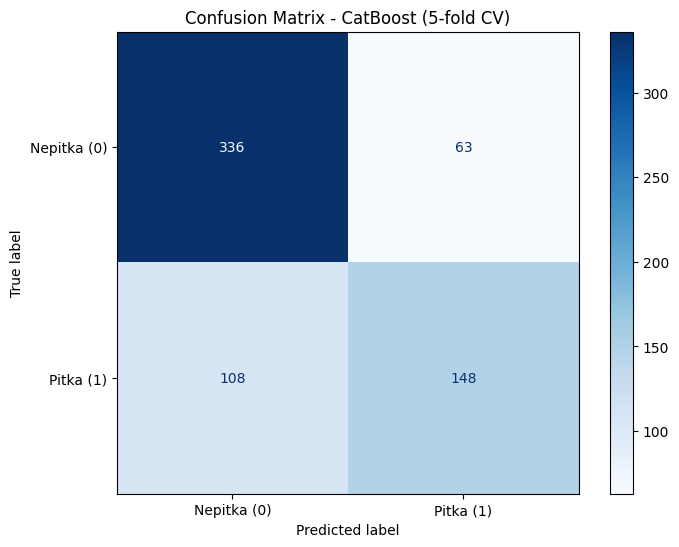

True Negatives (TN): 336
False Positives (FP): 63
False Negatives (FN): 108
True Positives (TP): 148

Accuracy: 0.7389
Precision (Pitka): 0.7014
Recall (Pitka): 0.5781
F1 Score (Pitka): 0.6338


In [55]:
# =============================================================================
# EVALUACIJA NAJBOLJEG MODELA - Cross-Validation sa matricom konfuzije
# =============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

# Priprema podataka
X = df_test.drop('Potability', axis=1)
y = df_test['Potability']

# CatBoost model
model = CatBoostClassifier(random_strength=2, learning_rate=0.03, l2_leaf_reg=3, iterations=1000, depth=10, bagging_temperature=0)

#model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)

# Cross-validation predikcije (svaki uzorak se predvidja kad je u test foldu)
y_pred_cv = cross_val_predict(model, X, y, cv=5)
y_pred_proba_cv = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Cross-validation scores
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("CROSS-VALIDATION REZULTATI (5-fold):")
print("="*60)
print(f"Accuracy po foldovima: {cv_scores}")
print(f"Prosecna accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Classification report
print("\nCLASSIFICATION REPORT (cross-validated):")
print("="*60)
print(classification_report(y, y_pred_cv, target_names=['Nepitka (0)', 'Pitka (1)']))

# Confusion Matrix (agregirana iz svih foldova)
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nepitka (0)', 'Pitka (1)'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix - CatBoost (5-fold CV)')
plt.show()

# Prikaz vrednosti
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nAccuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision (Pitka): {tp / (tp + fp):.4f}")
print(f"Recall (Pitka): {tp / (tp + fn):.4f}")
print(f"F1 Score (Pitka): {2*tp / (2*tp + fp + fn):.4f}")

0:	learn: 0.6778372	total: 14.2ms	remaining: 14.2s
1:	learn: 0.6657659	total: 28ms	remaining: 14s
2:	learn: 0.6535690	total: 43.2ms	remaining: 14.3s
3:	learn: 0.6423570	total: 57.5ms	remaining: 14.3s
4:	learn: 0.6303999	total: 70.1ms	remaining: 14s
5:	learn: 0.6188004	total: 82.8ms	remaining: 13.7s
6:	learn: 0.6080096	total: 95.9ms	remaining: 13.6s
7:	learn: 0.5975651	total: 109ms	remaining: 13.5s
8:	learn: 0.5891498	total: 122ms	remaining: 13.5s
9:	learn: 0.5793575	total: 135ms	remaining: 13.3s
10:	learn: 0.5727900	total: 148ms	remaining: 13.3s
11:	learn: 0.5622899	total: 161ms	remaining: 13.3s
12:	learn: 0.5519946	total: 175ms	remaining: 13.3s
13:	learn: 0.5414070	total: 188ms	remaining: 13.2s
14:	learn: 0.5322931	total: 200ms	remaining: 13.1s
15:	learn: 0.5249960	total: 213ms	remaining: 13.1s
16:	learn: 0.5157624	total: 226ms	remaining: 13.1s
17:	learn: 0.5060015	total: 240ms	remaining: 13.1s
18:	learn: 0.4980195	total: 252ms	remaining: 13s
19:	learn: 0.4908747	total: 265ms	remainin

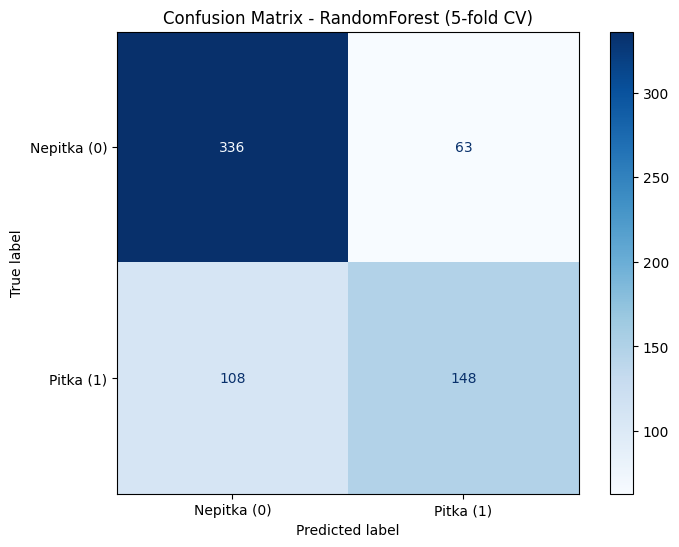

True Negatives (TN): 336
False Positives (FP): 63
False Negatives (FN): 108
True Positives (TP): 148

Accuracy: 0.7389
Precision (Pitka): 0.7014
Recall (Pitka): 0.5781
F1 Score (Pitka): 0.6338


In [56]:
# =============================================================================
# EVALUACIJA NAJBOLJEG MODELA - Cross-Validation sa matricom konfuzije
# =============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

# Priprema podataka
X = df_test.drop('Potability', axis=1)
y = df_test['Potability']

# RandomForest model
model = CatBoostClassifier(random_strength=2, learning_rate=0.03, l2_leaf_reg=3, iterations=1000, depth=10, bagging_temperature=0)

# Cross-validation predikcije (svaki uzorak se predvidja kad je u test foldu)
y_pred_cv = cross_val_predict(model, X, y, cv=5)
y_pred_proba_cv = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Cross-validation scores
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("CROSS-VALIDATION REZULTATI (5-fold):")
print("="*60)
print(f"Accuracy po foldovima: {cv_scores}")
print(f"Prosecna accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Classification report
print("\nCLASSIFICATION REPORT (cross-validated):")
print("="*60)
print(classification_report(y, y_pred_cv, target_names=['Nepitka (0)', 'Pitka (1)']))

# Confusion Matrix (agregirana iz svih foldova)
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nepitka (0)', 'Pitka (1)'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix - RandomForest (5-fold CV)')
plt.show()

# Prikaz vrednosti
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nAccuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision (Pitka): {tp / (tp + fp):.4f}")
print(f"Recall (Pitka): {tp / (tp + fn):.4f}")
print(f"F1 Score (Pitka): {2*tp / (2*tp + fp + fn):.4f}")

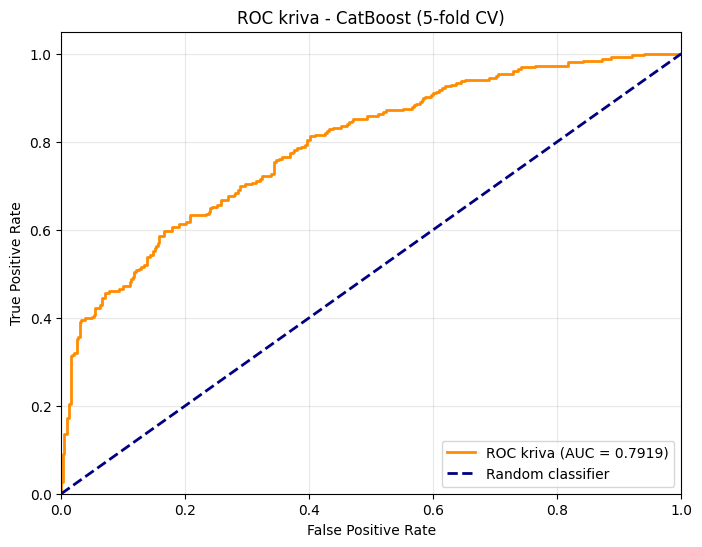

AUC Score: 0.7919


In [57]:
# ROC kriva i AUC (cross-validated)
fpr, tpr, thresholds = roc_curve(y, y_pred_proba_cv)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC kriva (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC kriva - CatBoost (5-fold CV)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

### Sumarna tabela: Baseline vs Finalni model

0:	learn: 0.6804223	total: 4.97ms	remaining: 2.48s
1:	learn: 0.6639178	total: 8.87ms	remaining: 2.21s
2:	learn: 0.6557115	total: 12.6ms	remaining: 2.09s
3:	learn: 0.6377066	total: 16.4ms	remaining: 2.03s
4:	learn: 0.6216250	total: 20.3ms	remaining: 2.01s
5:	learn: 0.6099973	total: 24.5ms	remaining: 2.02s
6:	learn: 0.6016930	total: 28.3ms	remaining: 2s
7:	learn: 0.5893160	total: 32.2ms	remaining: 1.98s
8:	learn: 0.5864680	total: 35.8ms	remaining: 1.95s
9:	learn: 0.5745858	total: 39ms	remaining: 1.91s
10:	learn: 0.5657094	total: 42.5ms	remaining: 1.89s
11:	learn: 0.5559338	total: 45.6ms	remaining: 1.86s
12:	learn: 0.5490109	total: 48.9ms	remaining: 1.83s
13:	learn: 0.5402757	total: 52.4ms	remaining: 1.82s
14:	learn: 0.5333188	total: 55.5ms	remaining: 1.79s
15:	learn: 0.5261996	total: 59ms	remaining: 1.78s
16:	learn: 0.5201173	total: 62.1ms	remaining: 1.76s
17:	learn: 0.5142521	total: 65.3ms	remaining: 1.75s
18:	learn: 0.5086998	total: 68.8ms	remaining: 1.74s
19:	learn: 0.5045852	total: 7

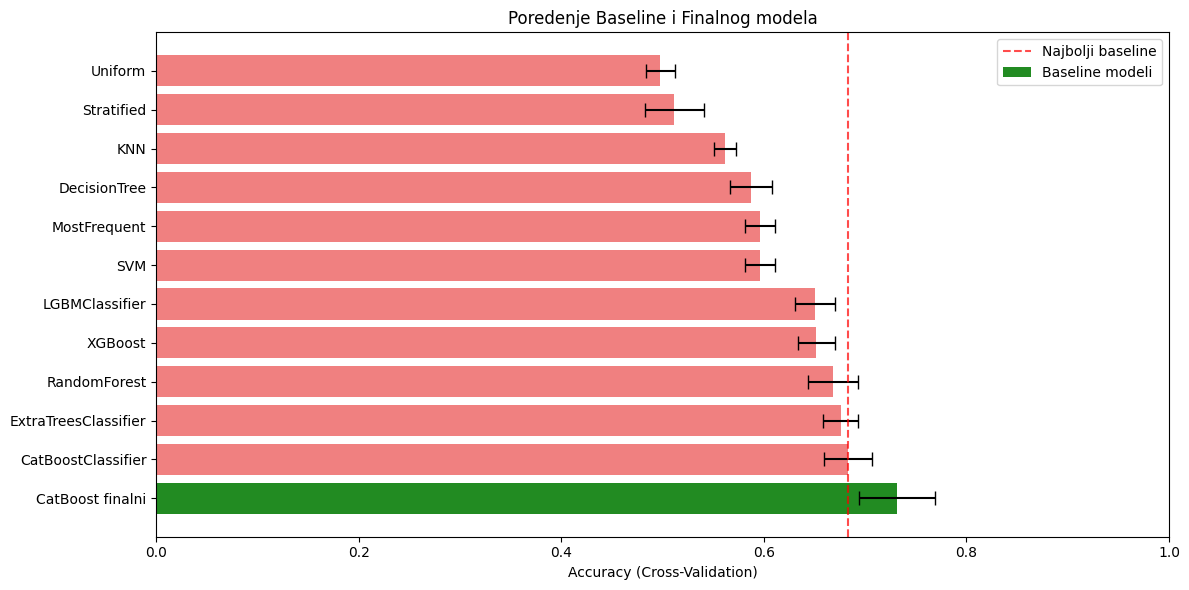


Poboljsanje u odnosu na najbolji baseline: 7.03%
Baseline (best): 0.6833 -> Finalni: 0.7313


In [58]:
# Sumarna tabela: Baseline vs Finalni rezultati
from sklearn.metrics import precision_score, recall_score, f1_score

# Finalni model accuracy (sa CV)
kf_final = KFold(n_splits=5, shuffle=True, random_state=42)
final_model_for_cv = CatBoostClassifier(random_strength=2, learning_rate=0.05, l2_leaf_reg=5, iterations=500, depth=8, bagging_temperature=0)


final_cv_scores = cross_val_score(final_model_for_cv, X, y, cv=kf_final)

# Kreiranje sumarne tabele
summary_data = {
    'Model': [],
    'Accuracy (CV)': [],
    'Std': [],
    'Tip': []
}

# Baseline rezultati
for name, result in baseline_results_cv.items():
    summary_data['Model'].append(name)
    summary_data['Accuracy (CV)'].append(result['mean'])
    summary_data['Std'].append(result['std'])
    summary_data['Tip'].append('Baseline')

# Finalni model
summary_data['Model'].append('CatBoost finalni')
summary_data['Accuracy (CV)'].append(final_cv_scores.mean())
summary_data['Std'].append(final_cv_scores.std())
summary_data['Tip'].append('Finalni')

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Accuracy (CV)', ascending=False)

print("=" * 70)
print("SUMARNA TABELA: BASELINE vs FINALNI MODEL")
print("=" * 70)
print(summary_df.to_string(index=False))
print("=" * 70)

# Vizualizacija
plt.figure(figsize=(12, 6))
colors = ['lightcoral' if t == 'Baseline' else 'forestgreen' for t in summary_df['Tip']]
bars = plt.barh(summary_df['Model'], summary_df['Accuracy (CV)'], color=colors, xerr=summary_df['Std'], capsize=5)
plt.xlabel('Accuracy (Cross-Validation)')
plt.title('Poredenje Baseline i Finalnog modela')
plt.xlim(0, 1)
plt.axvline(x=summary_df[summary_df['Tip']=='Baseline']['Accuracy (CV)'].max(), 
            color='red', linestyle='--', alpha=0.7, label='Najbolji baseline')
plt.legend(['Najbolji baseline', 'Baseline modeli', 'Finalni model'])
plt.tight_layout()
plt.show()

# Poboljsanje
baseline_best = summary_df[summary_df['Tip']=='Baseline']['Accuracy (CV)'].max()
final_acc = summary_df[summary_df['Tip']=='Finalni']['Accuracy (CV)'].values[0]
improvement = ((final_acc - baseline_best) / baseline_best) * 100
print(f"\nPoboljsanje u odnosu na najbolji baseline: {improvement:.2f}%")
print(f"Baseline (best): {baseline_best:.4f} -> Finalni: {final_acc:.4f}")

### Feature Importance (Vaznost osobina)

Feature Importance pokazuje koliko svaka osobina doprinosi predikcijama modela. 
Moze da sadrzi:

- **Visoku vaznost**: Osobina ima veliki uticaj na predikcije
- **Nisku vaznost**: Osobina malo doprinosi - moze se eventualno ukloniti
- **Relativnu vrednost**: Vaznost je normalizovana (suma = 1)

Ocekujemo da hemijski parametri poput pH, Sulfata i tvrdoce vode budu medju najvaznijim jer:
- pH direktno utice na pitkost (7 je neutralno)
- Sulfati u visokim koncentracijama mogu biti stetni
- Tvrdoca vode utice na ukus i upotrebljivost

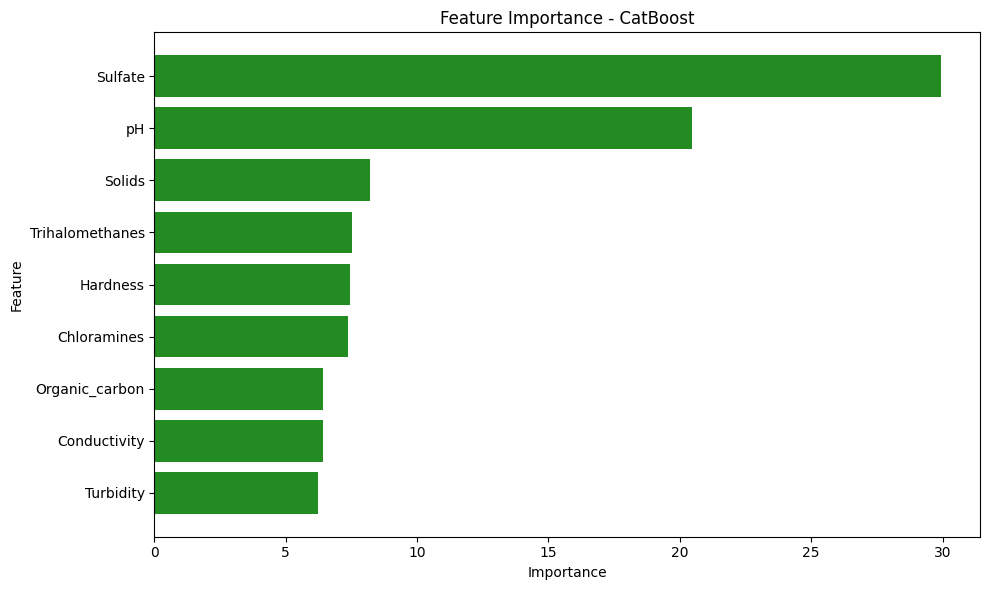


Feature Importance ranking (CatBoost):
  Sulfate: 29.9305
  pH: 20.4685
  Solids: 8.1950
  Trihalomethanes: 7.5321
  Hardness: 7.4534
  Chloramines: 7.3524
  Organic_carbon: 6.4248
  Conductivity: 6.4164
  Turbidity: 6.2269


In [59]:
# Feature Importance - CatBoost
# Treniraj model na celom datasetu za feature importance
X = df.drop('Potability', axis=1)
y = df['Potability']
features = X.columns.tolist()

model_fi = CatBoostClassifier(random_strength=2, learning_rate=0.05, l2_leaf_reg=5, iterations=500, depth=8, bagging_temperature=0, verbose=0)

model_fi.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model_fi.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='forestgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoost')
plt.tight_layout()
plt.show()

print("\nFeature Importance ranking (CatBoost):")
for idx, row in feature_importance.sort_values('importance', ascending=False).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

## Analiza interpretabilnosti modela (LIME i SHAP)

SHAP racuna doprinos svake osobine predikciji koristeci Shapley vrednosti iz teorije igara:
1. Za svaku osobinu, racuna se koliko bi se predikcija promenila ako tu osobinu "izbacimo"
2. Ovo se radi za sve moguce kombinacije osobina
3. Rezultat je ponderisani prosek doprinosa

LIME (Local Interpretable Model-agnostic Explanations):
1. Uzima instancu koju zelimo objasniti
2. Pravi perturbacije (varijacije) oko te instance
3. Trenira jednostavan linearni model na tim perturbacijama
4. Koeficijenti linearnog modela = objasnjenje


In [60]:
import shap
import lime
import lime.lime_tabular
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ============================================================================
# SHAP I LIME NA OBRAĐENIM PODACIMA
# ============================================================================
# NAPOMENA: df je već TRAIN SET (splitovanje urađeno u cell 7)
# df_test već postoji i koristi se za finalno testiranje

# Priprema podataka - koristimo df (koji je već df_train!)
X_train = df.drop('Potability', axis=1)
y_train = df['Potability']

# Test podaci - koristi se već postojeći df_test
X_test = df_test.drop('Potability', axis=1)
y_test = df_test['Potability']

features = X_train.columns.tolist()

print("=" * 70)
print("PRIPREMA PODATAKA ZA SHAP/LIME ANALIZU")
print("=" * 70)
print("✓ Koristi se već postojeći train/test split iz cell 7")
print(f"Train set: {len(X_train)} uzoraka (df = df_train)")
print(f"Test set:  {len(X_test)} uzoraka (df_test)")

# OBRADA PODATAKA - imputacija fitovana NA TRAIN setu
print("\n1. Imputacija podataka...")
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)  # FIT na train
X_test_imputed = imputer.transform(X_test)        # TRANSFORM test

# Konvertuj nazad u DataFrame da bi zadržali imena kolona
X_train_processed = pd.DataFrame(X_train_imputed, columns=features)
X_test_processed = pd.DataFrame(X_test_imputed, columns=features)

print("   ✓ Null vrednosti imputirane (strategija: mean)")
print(f"   ✓ Train set: {X_train_processed.isnull().sum().sum()} null vrednosti")
print(f"   ✓ Test set:  {X_test_processed.isnull().sum().sum()} null vrednosti")

# TRENIRANJE MODELA NA OBRAĐENIM PODACIMA
print("\n2. Treniranje CatBoost modela...")
model = CatBoostClassifier(
    random_strength=2, 
    learning_rate=0.05, 
    l2_leaf_reg=5, 
    iterations=500, 
    depth=8, 
    bagging_temperature=0, 
    verbose=0
)

model.fit(X_train_processed, y_train)
print("   ✓ Model obučen na obrađenim train podacima")

# EVALUACIJA
y_pred = model.predict(X_test_processed)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
test_accuracy = (y_pred == y_test).mean()

print(f"\n3. Evaluacija na test setu:")
print(f"   Test Accuracy: {test_accuracy:.4f}")

# SHAP ANALIZA NA OBRAĐENIM TEST PODACIMA
print("\n4. Kreiranje SHAP explainer-a...")
explainer_shap = shap.TreeExplainer(model)

print("   Računanje SHAP vrednosti na OBRAĐENIM test podacima...")
shap_values = explainer_shap.shap_values(X_test_processed)
print("   ✓ SHAP vrednosti izračunate!")

# LIME EXPLAINER SA OBRAĐENIM TRAIN PODACIMA
print("\n5. Kreiranje LIME explainer-a...")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_processed.values,  # Background iz obrađenog train seta
    feature_names=features,
    class_names=['Nepitka', 'Pitka'],
    mode='classification'
)
print("   ✓ LIME explainer inicijalizovan sa obrađenim train podacima")

print("\n" + "=" * 70)
print("PRIPREMA ZAVRŠENA - Podaci spremni za SHAP/LIME vizualizacije")
print("=" * 70)

# Ažuriraj X_test za dalje korišćenje u vizualizacijama
X_test = X_test_processed

c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PRIPREMA PODATAKA ZA SHAP/LIME ANALIZU
✓ Koristi se već postojeći train/test split iz cell 7
Train set: 3086 uzoraka (df = df_train)
Test set:  655 uzoraka (df_test)

1. Imputacija podataka...
   ✓ Null vrednosti imputirane (strategija: mean)
   ✓ Train set: 0 null vrednosti
   ✓ Test set:  0 null vrednosti

2. Treniranje CatBoost modela...
   ✓ Model obučen na obrađenim train podacima

3. Evaluacija na test setu:
   Test Accuracy: 0.6183

4. Kreiranje SHAP explainer-a...
   Računanje SHAP vrednosti na OBRAĐENIM test podacima...
   ✓ SHAP vrednosti izračunate!

5. Kreiranje LIME explainer-a...
   ✓ LIME explainer inicijalizovan sa obrađenim train podacima

PRIPREMA ZAVRŠENA - Podaci spremni za SHAP/LIME vizualizacije


### SHAP Summary Plot
Summary plot prikazuje uticaj svake osobine na predikcije modela. Svaka tacka predstavlja jedan uzorak, a boja pokazuje vrednost osobine (crvena = visoka, plava = niska).

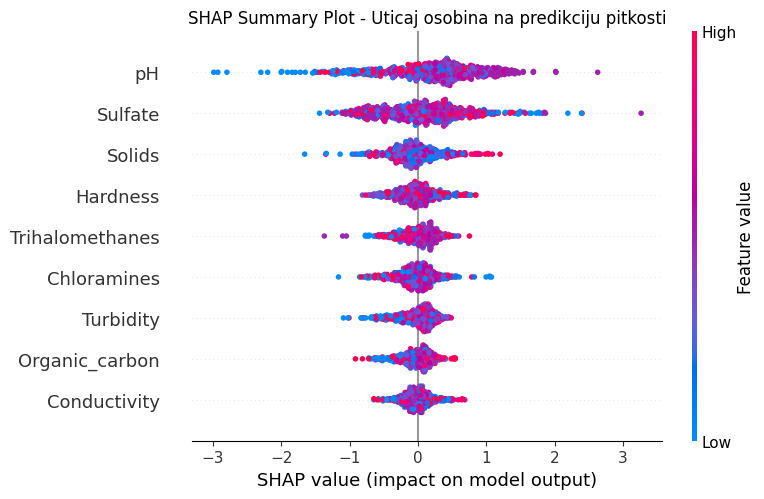

In [61]:
# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=features, show=False)
plt.title('SHAP Summary Plot - Uticaj osobina na predikciju pitkosti')
plt.tight_layout()
plt.show()

### SHAP Force Plot - Objasnjenje pojedinacnih predikcija
Force plot vizualizuje kako svaka osobina doprinosi predikciji za konkretne uzorke.

=== Objasnjenje predikcije za uzorak klasifikovan kao PITKA voda ===
Uzorak index: 12
Prava klasa: 1
Predvidjena klasa: 1
Verovatnoca pitkosti: 0.6732


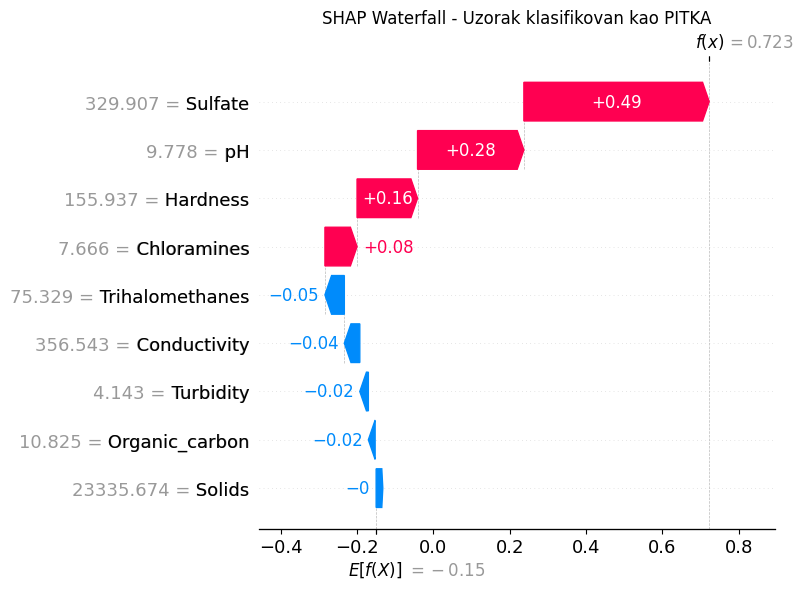

In [62]:
# Force plot za uzorke
# Pronalazenje uzoraka po klasama
pitka_indices = np.where(y_pred == 1)[0]
nepitka_indices = np.where(y_pred == 0)[0]

print("=== Objasnjenje predikcije za uzorak klasifikovan kao PITKA voda ===")
if len(pitka_indices) > 0:
    sample_idx = pitka_indices[0]
    print(f"Uzorak index: {sample_idx}")
    print(f"Prava klasa: {y_test.iloc[sample_idx]}")
    print(f"Predvidjena klasa: {y_pred[sample_idx]}")
    print(f"Verovatnoca pitkosti: {y_pred_proba[sample_idx]:.4f}")

    # SHAP waterfall plot
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[sample_idx],
        base_values=explainer_shap.expected_value,
        data=X_test.iloc[sample_idx],
        feature_names=features
    ), show=False)
    plt.title('SHAP Waterfall - Uzorak klasifikovan kao PITKA')
    plt.tight_layout()
    plt.show()
else:
    print("Nema uzoraka klasifikovanih kao pitka voda")

=== Objasnjenje predikcije za uzorak klasifikovan kao NEPITKA voda ===
Uzorak index: 0
Prava klasa: 1
Predvidjena klasa: 0
Verovatnoca pitkosti: 0.3269


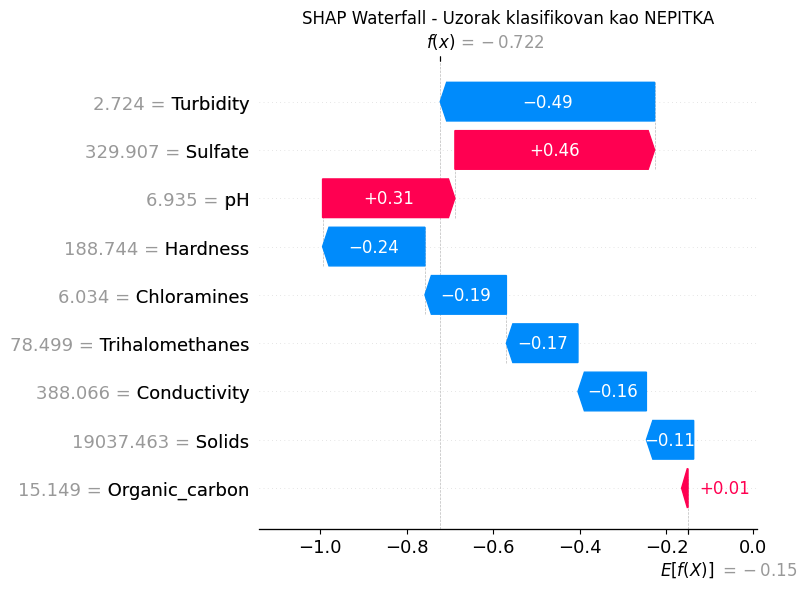

In [63]:
print("=== Objasnjenje predikcije za uzorak klasifikovan kao NEPITKA voda ===")
if len(nepitka_indices) > 0:
    sample_idx_neg = nepitka_indices[0]
    print(f"Uzorak index: {sample_idx_neg}")
    print(f"Prava klasa: {y_test.iloc[sample_idx_neg]}")
    print(f"Predvidjena klasa: {y_pred[sample_idx_neg]}")
    print(f"Verovatnoca pitkosti: {y_pred_proba[sample_idx_neg]:.4f}")

    # SHAP waterfall plot za nepitku
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[sample_idx_neg],
        base_values=explainer_shap.expected_value,
        data=X_test.iloc[sample_idx_neg],
        feature_names=features
    ), show=False)
    plt.title('SHAP Waterfall - Uzorak klasifikovan kao NEPITKA')
    plt.tight_layout()
    plt.show()
else:
    print("Nema uzoraka klasifikovanih kao nepitka voda")

ANALIZA FALSE POSITIVE PRIMERA
Ukupno false positiva: 63
Procenat false positiva: 9.62%

=== FALSE POSITIVE - Niska pouzdanost ===
Uzorak index: 1
Prava klasa: 0 (Nepitka - ISPRAVNO)
Predvidjena klasa: 1 (Pitka - POGREŠNO)
Verovatnoca pitkosti: 0.6245

Vrednosti osobina:
  pH                   = 6.1725
  Hardness             = 187.7870
  Solids               = 10498.6352
  Chloramines          = 7.7226
  Sulfate              = 322.5210
  Conductivity         = 467.0904
  Organic_carbon       = 21.2340
  Trihalomethanes      = 68.1636
  Turbidity            = 4.1300

=== SHAP objasnjenje za False Positive ===


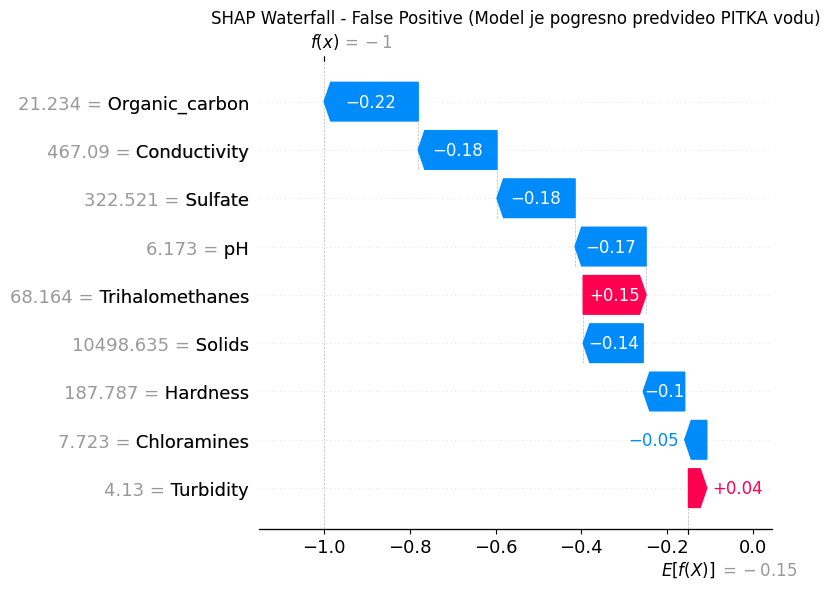


=== LIME objasnjenje za False Positive ===


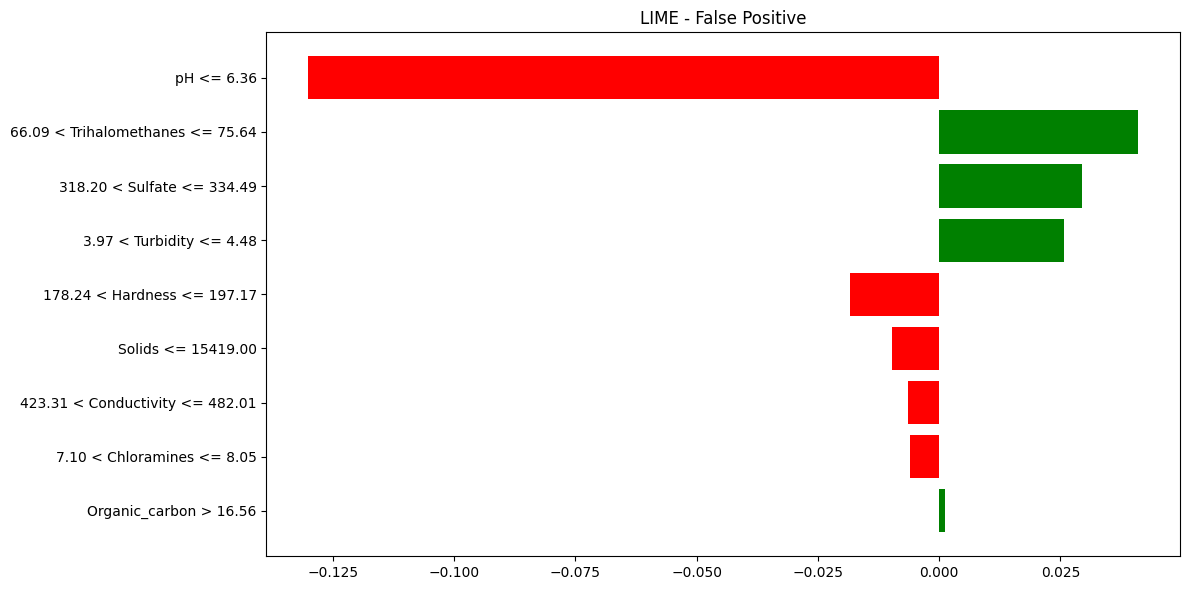


LIME feature weights:
  pH <= 6.36: -0.1301
  66.09 < Trihalomethanes <= 75.64: 0.0411
  318.20 < Sulfate <= 334.49: 0.0294
  3.97 < Turbidity <= 4.48: 0.0258
  178.24 < Hardness <= 197.17: -0.0183
  Solids <= 15419.00: -0.0097
  423.31 < Conductivity <= 482.01: -0.0065
  7.10 < Chloramines <= 8.05: -0.0061
  Organic_carbon > 16.56: 0.0012


=== FALSE POSITIVE - VISOKA POUZDANOST ===
Uzorak index: 577
Prava klasa: 0 (Nepitka - ISPRAVNO)
Predvidjena klasa: 1 (Pitka - POGREŠNO)
Verovatnoca pitkosti: 0.9855

Vrednosti osobina:
  pH                   = 9.4671
  Hardness             = 169.2144
  Solids               = 33365.3154
  Chloramines          = 8.4605
  Sulfate              = 315.9604
  Conductivity         = 449.7240
  Organic_carbon       = 10.3968
  Trihalomethanes      = 74.3269
  Turbidity            = 3.1642

=== SHAP objasnjenje za High-Confidence False Positive ===


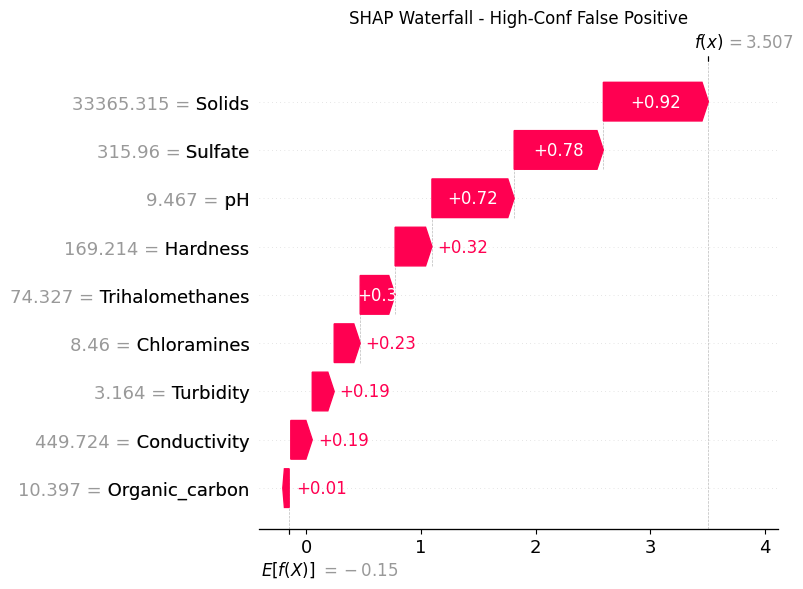

In [64]:
# Pronalazenje false positive primera (predvidjeno 1, a stvarno 0)
false_positives = np.where((y_pred_cv == 1) & (y_test == 0))[0]

print("=" * 70)
print("ANALIZA FALSE POSITIVE PRIMERA")
print("=" * 70)
print(f"Ukupno false positiva: {len(false_positives)}")
print(f"Procenat false positiva: {len(false_positives)/len(y_test)*100:.2f}%")

if len(false_positives) > 0:
    # Pronalazanje FP sa najvećom pouzdanošću (visoka verovatnoća za klasu 1)
    fp_idx = false_positives[0]
    highest_conf_fp = false_positives[np.argmax(y_pred_proba_cv[false_positives])]
    
    print(f"\n=== FALSE POSITIVE - Niska pouzdanost ===")
    print(f"Uzorak index: {fp_idx}")
    print(f"Prava klasa: {y_test.iloc[fp_idx]} (Nepitka - ISPRAVNO)")
    print(f"Predvidjena klasa: {y_pred_cv[fp_idx]} (Pitka - POGREŠNO)")
    print(f"Verovatnoca pitkosti: {y_pred_proba_cv[fp_idx]:.4f}")
    
    print(f"\nVrednosti osobina:")
    for feat, val in zip(X_test.columns, X_test.iloc[fp_idx].values):
        print(f"  {feat:20} = {val:.4f}")
    
    # SHAP objasnjenje za FP
    print(f"\n=== SHAP objasnjenje za False Positive ===")
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[fp_idx],
        base_values=explainer_shap.expected_value,
        data=X_test.iloc[fp_idx],
        feature_names=features
    ), show=False)
    plt.title(f'SHAP Waterfall - False Positive (Model je pogresno predvideo PITKA vodu)')
    plt.tight_layout()
    plt.show()
    
    # LIME objasnjenje za FP
    print(f"\n=== LIME objasnjenje za False Positive ===")
    lime_exp_fp = lime_explainer.explain_instance(
        X_test.values[fp_idx],
        model.predict_proba,
        num_features=9
    )
    
    fig = lime_exp_fp.as_pyplot_figure()
    fig.set_size_inches(12, 6)
    plt.title(f'LIME - False Positive')
    plt.tight_layout()
    plt.show()
    
    print("\nLIME feature weights:")
    for feat, weight in lime_exp_fp.as_list():
        print(f"  {feat}: {weight:.4f}")
    
    # FP sa najvećom pouzdanošću
    print(f"\n\n=== FALSE POSITIVE - VISOKA POUZDANOST ===")
    print(f"Uzorak index: {highest_conf_fp}")
    print(f"Prava klasa: {y_test.iloc[highest_conf_fp]} (Nepitka - ISPRAVNO)")
    print(f"Predvidjena klasa: {y_pred_cv[highest_conf_fp]} (Pitka - POGREŠNO)")
    print(f"Verovatnoca pitkosti: {y_pred_proba_cv[highest_conf_fp]:.4f}")
    
    print(f"\nVrednosti osobina:")
    for feat, val in zip(X_test.columns, X_test.iloc[highest_conf_fp].values):
        print(f"  {feat:20} = {val:.4f}")
    
    # SHAP objasnjenje za FP sa visokom pouzdanošću
    print(f"\n=== SHAP objasnjenje za High-Confidence False Positive ===")
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[highest_conf_fp],
        base_values=explainer_shap.expected_value,
        data=X_test.iloc[highest_conf_fp],
        feature_names=features
    ), show=False)
    plt.title(f'SHAP Waterfall - High-Conf False Positive')
    plt.tight_layout()
    plt.show()

else:
    print("Nema false positive primera!")

### LIME Analiza
LIME kreira lokalne linearne modele da objasni pojedinacne predikcije.

=== LIME Objasnjenje za uzorak klasifikovan kao PITKA voda ===


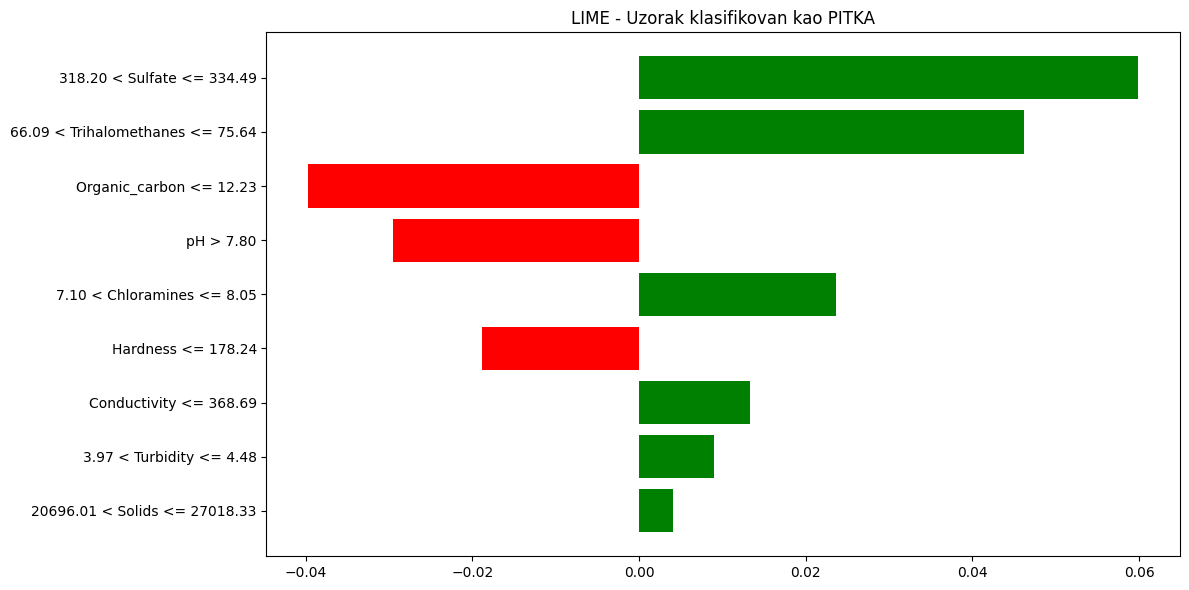


LIME feature weights:
  318.20 < Sulfate <= 334.49: 0.0599
  66.09 < Trihalomethanes <= 75.64: 0.0462
  Organic_carbon <= 12.23: -0.0397
  pH > 7.80: -0.0296
  7.10 < Chloramines <= 8.05: 0.0237
  Hardness <= 178.24: -0.0189
  Conductivity <= 368.69: 0.0133
  3.97 < Turbidity <= 4.48: 0.0089
  20696.01 < Solids <= 27018.33: 0.0041


In [65]:
# Kreiranje LIME explainera
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=features,
    class_names=['Nepitka', 'Pitka'],
    mode='classification',
    random_state=42
)

# LIME objasnjenje za uzorak klasifikovan kao pitka voda
print("=== LIME Objasnjenje za uzorak klasifikovan kao PITKA voda ===")
if len(pitka_indices) > 0:
    lime_exp_pitka = lime_explainer.explain_instance(
        X_test.values[sample_idx],
        model.predict_proba,
        num_features=9
    )

    # Prikaz LIME objasnjenja
    fig = lime_exp_pitka.as_pyplot_figure()
    fig.set_size_inches(12, 6)
    plt.title('LIME - Uzorak klasifikovan kao PITKA')
    plt.tight_layout()
    plt.show()

    print("\nLIME feature weights:")
    for feat, weight in lime_exp_pitka.as_list():
        print(f"  {feat}: {weight:.4f}")

=== LIME - uzorak klasifikovan kao NEPITKA voda ===


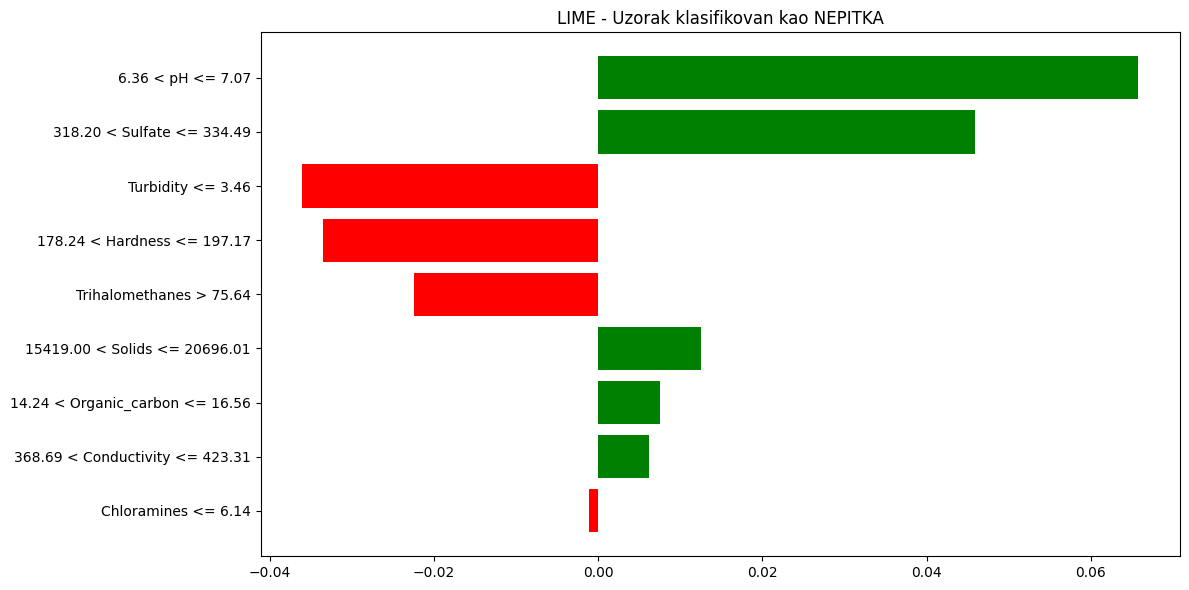


LIME feature weights:
  6.36 < pH <= 7.07: 0.0658
  318.20 < Sulfate <= 334.49: 0.0458
  Turbidity <= 3.46: -0.0360
  178.24 < Hardness <= 197.17: -0.0335
  Trihalomethanes > 75.64: -0.0224
  15419.00 < Solids <= 20696.01: 0.0126
  14.24 < Organic_carbon <= 16.56: 0.0075
  368.69 < Conductivity <= 423.31: 0.0062
  Chloramines <= 6.14: -0.0011


In [66]:
# LIME objasnjenje za uzorak klasifikovan kao nepitka voda
print("=== LIME - uzorak klasifikovan kao NEPITKA voda ===")
if len(nepitka_indices) > 0:
    lime_exp_nepitka = lime_explainer.explain_instance(
        X_test.values[sample_idx_neg],
        model.predict_proba,
        num_features=9
    )

    # Prikaz LIME objasnjenja
    fig = lime_exp_nepitka.as_pyplot_figure()
    fig.set_size_inches(12, 6)
    plt.title('LIME - Uzorak klasifikovan kao NEPITKA')
    plt.tight_layout()
    plt.show()

    print("\nLIME feature weights:")
    for feat, weight in lime_exp_nepitka.as_list():
        print(f"  {feat}: {weight:.4f}")

## Redukcija dimenzionalnosti (PCA)

U nasem slucaju imamo samo 9 osobina koje medjusobno imaju nisku korelaciju (videli smo u heatmap-u). Ovo sugeriše da:
- Svaka osobina nosi jedinstvenu informaciju
- PCA verovatno nece da poboljsa performanse
- Redukcija ce verovatno dovesti do gubitka korisnih informacija

## Analiza uticaja koraka preprocesiranja na performanse modela

Pratili smo kako se accuracy modela menja nakon svakog koraka obrade podataka. Ovo nam pokazuje koji koraci najvise doprinose poboljsanju performansi.

PCA ANALIZA SA PRAVILNO OBRAĐENIM PODACIMA
✓ Koristi se već postojeći train/test split iz cell 7
Train set: 3086 uzoraka (df = df_train)
Test set:  655 uzoraka (df_test)

1. Imputacija podataka...
   ✓ Null vrednosti imputirane

2. Skaliranje podataka...
   ✓ Podaci standardizovani

3. PCA analiza...
   ✓ PCA fitovana na obrađenim train podacima


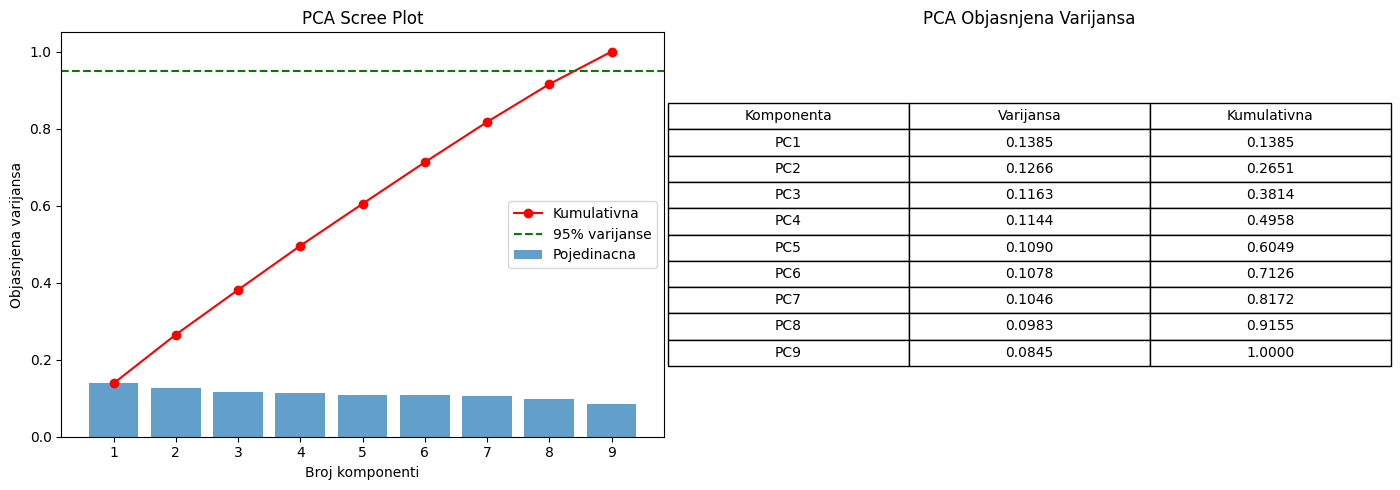


Broj komponenti potrebnih za 95% varijanse: 9
Originalni broj osobina: 9


In [67]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

print("=" * 70)
print("PCA ANALIZA SA PRAVILNO OBRAĐENIM PODACIMA")
print("=" * 70)
print("✓ Koristi se već postojeći train/test split iz cell 7")

# Priprema podataka - koristimo df (koji je već df_train!)
X_train = df.drop('Potability', axis=1)
y_train = df['Potability']

# Test podaci - koristi se već postojeći df_test
X_test = df_test.drop('Potability', axis=1)
y_test = df_test['Potability']

features = X_train.columns.tolist()

print(f"Train set: {len(X_train)} uzoraka (df = df_train)")
print(f"Test set:  {len(X_test)} uzoraka (df_test)")

# 1. IMPUTACIJA - fitovana NA TRAIN setu
print("\n1. Imputacija podataka...")
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
print("   ✓ Null vrednosti imputirane")

# 2. SKALIRANJE - fitovano NA TRAIN setu (potrebno za PCA)
print("\n2. Skaliranje podataka...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
print("   ✓ Podaci standardizovani")

# 3. PCA analiza na OBRAĐENIM i standardizovanim podacima
print("\n3. PCA analiza...")
pca_full = PCA()
pca_full.fit(X_train_scaled)
print("   ✓ PCA fitovana na obrađenim train podacima")

# Kumulativna objašnjena varijansa
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, alpha=0.7, label='Pojedinacna')
axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
             'r-o', label='Kumulativna')
axes[0].axhline(y=0.95, color='g', linestyle='--', label='95% varijanse')
axes[0].set_xlabel('Broj komponenti')
axes[0].set_ylabel('Objasnjena varijansa')
axes[0].set_title('PCA Scree Plot')
axes[0].legend()
axes[0].set_xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))

# Tabela sa detaljima
axes[1].axis('off')
table_data = []
for i, (var, cum_var) in enumerate(zip(pca_full.explained_variance_ratio_, cumulative_variance)):
    table_data.append([f'PC{i+1}', f'{var:.4f}', f'{cum_var:.4f}'])
table = axes[1].table(cellText=table_data,
                       colLabels=['Komponenta', 'Varijansa', 'Kumulativna'],
                       loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1].set_title('PCA Objasnjena Varijansa')

plt.tight_layout()
plt.show()

# Pronalazenje broja komponenti za 95% varijanse
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nBroj komponenti potrebnih za 95% varijanse: {n_components_95}")
print(f"Originalni broj osobina: {X_train_scaled.shape[1]}")

### Evaluacija modela sa razlicitim brojem PCA komponenti

In [68]:
# Testiranje CatBoost sa razlicitim brojem PCA komponenti
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

n_components_range = range(2, 10)
pca_results = []

for n_comp in n_components_range:
    # PCA transformacija
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Treniranje modela
    model_pca = CatBoostClassifier(random_strength=2, learning_rate=0.05, l2_leaf_reg=5, iterations=500, depth=8, bagging_temperature=0, verbose=0)
    model_pca.fit(X_train_pca, y_train)

    # Evaluacija
    y_pred_pca = model_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test, y_pred_pca)

    # Cross-validation
    cv_scores = cross_val_score(model_pca, X_train_pca, y_train, cv=5)

    pca_results.append({
        'n_components': n_comp,
        'variance_explained': sum(pca.explained_variance_ratio_),
        'test_accuracy': accuracy_pca,
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std()
    })

pca_results_df = pd.DataFrame(pca_results)

# Rezultat bez PCA (CatBoost ne treba skaliranje)
model_no_pca = CatBoostClassifier(random_strength=2, learning_rate=0.05, l2_leaf_reg=5, iterations=500, depth=8, bagging_temperature=0, verbose=0)
model_no_pca.fit(X_train, y_train)
y_pred_no_pca = model_no_pca.predict(X_test)
cv_no_pca = cross_val_score(model_no_pca, X_train, y_train, cv=5)

print("Performanse CatBoost modela sa PCA redukcijom\n")
print(pca_results_df.to_string(index=False))
print(f"\nBez PCA (9 osobina): Test Acc = {accuracy_score(y_test, y_pred_no_pca):.4f}, CV Acc = {cv_no_pca.mean():.4f} (+/- {cv_no_pca.std():.4f})")

# Najbolji broj komponenti
best_pca_row = pca_results_df.loc[pca_results_df['cv_accuracy_mean'].idxmax()]
print(f"\nOptimalan broj komponenti: {int(best_pca_row['n_components'])}")

Performanse CatBoost modela sa PCA redukcijom

 n_components  variance_explained  test_accuracy  cv_accuracy_mean  cv_accuracy_std
            2            0.265140       0.516031          0.540842         0.026453
            3            0.381395       0.526718          0.535329         0.028812
            4            0.495819       0.531298          0.570007         0.032465
            5            0.604852       0.537405          0.592691         0.043110
            6            0.712627       0.528244          0.608887         0.032281
            7            0.817200       0.545038          0.640648         0.041344
            8            0.915460       0.607634          0.674665         0.041759
            9            1.000000       0.609160          0.691845         0.041604

Bez PCA (9 osobina): Test Acc = 0.6183, CV Acc = 0.8153 (+/- 0.0107)

Optimalan broj komponenti: 9


In [72]:
# Summary of preprocessing steps impact on model performance
# Data collected from evaluate_models_after_step() calls

preprocessing_summary = {
    'Korak': [
        'Baseline',
        '1. Missing vrednosti',
        '2. Nakon imputacije (Mean po grupi)',
        '3. Bez outliera (Z-score)',
        '4. Balansirano',
        '5. Optimizacija hp.'
    ],
    'Broj uzoraka': [3276, 3267,  3267, 3121, 3846, 3846],
    'Distribucija klasa': ['1990/1286 (60.7%/39.3%)', '1990/1277 (60.9%/39.1%)', '1990/1277 (60.9%/39.1%)', '1990/1277 (60.9%/39.1%)', '1990/1990 (50%/50%)', '1990/1990 (50%/50%)'],
    'Najbolji model': ['CatBoost', 'CatBoost','CatBoost', 'CatBoost', 'CatBoost', 'CatBoost'],
    'Accuracy': [67.0, 67.6, 80.3, 79.9, 77.0, 77.0]
}

summary_df = pd.DataFrame(preprocessing_summary)

# Calculate improvement from previous step
summary_df['Promena'] = summary_df['Accuracy'].diff()
summary_df['Promena %'] = summary_df['Accuracy'].pct_change() * 100
summary_df.loc[0, 'Promena'] = 0
summary_df.loc[0, 'Promena %'] = 0

print("="*90)
print("UTICAJ KORAKA PREPROCESIRANJA NA PERFORMANSE MODELA")
print("="*90)
print(summary_df.to_string(index=False))
print("\n")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy progression
ax1 = axes[0]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f1c40f']
bars = ax1.bar(range(len(summary_df)), summary_df['Accuracy'], color=colors, edgecolor='black', linewidth=1.2)
ax1.set_xticks(range(len(summary_df)))
ax1.set_xticklabels(['Baseline', 'Missing vrednosti','Imputacija', 'Bez outliera', 'Balansirano', 'Optimizacija hp.'], fontsize=11)
ax1.set_ylabel('Accuracy (5-fold CV)', fontsize=12)
ax1.set_title('Accuracy po koraku preprocesiranja', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 95)
ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Random baseline')

# Add value labels on bars
for bar, acc in zip(bars, summary_df['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Change from previous step
ax2 = axes[1]
changes = summary_df['Promena'].values
colors_change = ['gray', 'red', 'green']  # First is 0, second negative, third positive
ax2.bar(range(len(summary_df)), changes, color=colors_change, edgecolor='black', linewidth=1.2)
ax2.set_xticks(range(len(summary_df)))
ax2.set_xticklabels(['Baseline','Uklanjenje redova sa vise NaN','Imputacija', 'Bez outliera', 'Balansirano', 'Optimizacija hp.'], fontsize=10)
ax2.set_ylabel('Promena accuracy', fontsize=12)
ax2.set_title('Promena u odnosu na prethodni korak', fontsize=13, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for i, (change, pct) in enumerate(zip(changes, summary_df['Promena %'])):
    if change != 0:
        label = f'{change:+.4f}\n({pct:+.1f}%)'
        ax2.text(i, change + 0.002 if change > 0 else change - 0.008, 
                 label, ha='center', va='bottom' if change > 0 else 'top', fontsize=10)




UTICAJ KORAKA PREPROCESIRANJA NA PERFORMANSE MODELA
                              Korak  Broj uzoraka      Distribucija klasa Najbolji model  Accuracy  Promena  Promena %
                           Baseline          3276 1990/1286 (60.7%/39.3%)       CatBoost      67.0      0.0   0.000000
               1. Missing vrednosti          3267 1990/1277 (60.9%/39.1%)       CatBoost      67.6      0.6   0.895522
2. Nakon imputacije (Mean po grupi)          3267 1990/1277 (60.9%/39.1%)       CatBoost      80.3     12.7  18.786982
          3. Bez outliera (Z-score)          3121 1990/1277 (60.9%/39.1%)       CatBoost      79.9     -0.4  -0.498132
                     4. Balansirano          3846     1990/1990 (50%/50%)       CatBoost      77.0     -2.9  -3.629537
                5. Optimizacija hp.          3846     1990/1990 (50%/50%)       CatBoost      77.0      0.0   0.000000




## Finalna diskusija i analiza rezultata

### 1. Pregled koriscenih tehnika i metodologije

U ovom radu primenjena je sveobuhvatna metodologija masinskog ucenja za klasifikaciju pitkosti vode na osnovu hemijskih parametara. Analiza je obuhvatila sledece korake:

**Preprocesiranje podataka:**
- Imputacija nedostajucih vrednosti koriscenjem mean imputacije po grupama 
- Detekcija i uklanjanje outliera Z-score metodom (prag = 3)
- Balansiranje klasa smote upsampling tehnikom

**Treniranje i evaluacija modela:**
- Testiranje vise algoritama (KNN, SVM, DecisionTree, RandomForest, NaiveBayes, CatBoost, LGBM...)
- Uporedna analiza razlicitih skalera (StandardScaler, MinMaxScaler, RobustScaler i bez skaliranja)
- Optimizacija hiperparametara koriscenjem  RandomizedSearchCV
- K-Fold Cross-Validation za robusnu evaluaciju

### 2. Analiza interpretabilnosti modela

Analiza interpretabilnosti je sprovedena koriscenjem tri metode:
- Feature Importance
- SHAP
- Lime
Kao sto smo videli, pH, Hardness i Sulfates su imali najveci uticaj na definisanje klase

### 3. Analiza redukcije dimenzionalnosti (PCA)

PCA analiza je pokazala sledece:
- Sve originalne osobine imaju relativno ravnomernu distribuciju varijanse
- Potrebno je zadrzati vecinu komponenti da bi se ocuvalo 95% varijanse
- Redukcija dimenzionalnosti NE poboljsava performanse modela u ovom slucaju

**Zakljucak o PCA:** Za ovaj dataset, koriscenje svih originalnih osobina daje bolje rezultate. Ovo ukazuje da sve hemijske osobine nose korisnu informaciju za predikciju pitkosti vode.

### 4. Uticaj koraka preprocesiranja

Analiza inkrementalnog treniranja je pokazala:
1. **Imputacija** - Poboljsava potencijalno kvalitet podataka
2. **Uklanjanje outliera** - Cisti dataset i poboljsava generalizaciju
3. **Balansiranje klasa** - Kljucni korak koji znacajno poboljsava metrike
4. **Skaliranje** - zanemarljiva promena za tree-based modele, ali znatna promena za kNN i SVM modele
5. **Balansiranje klasa** je imalo najveci uticaj na metrike modela.

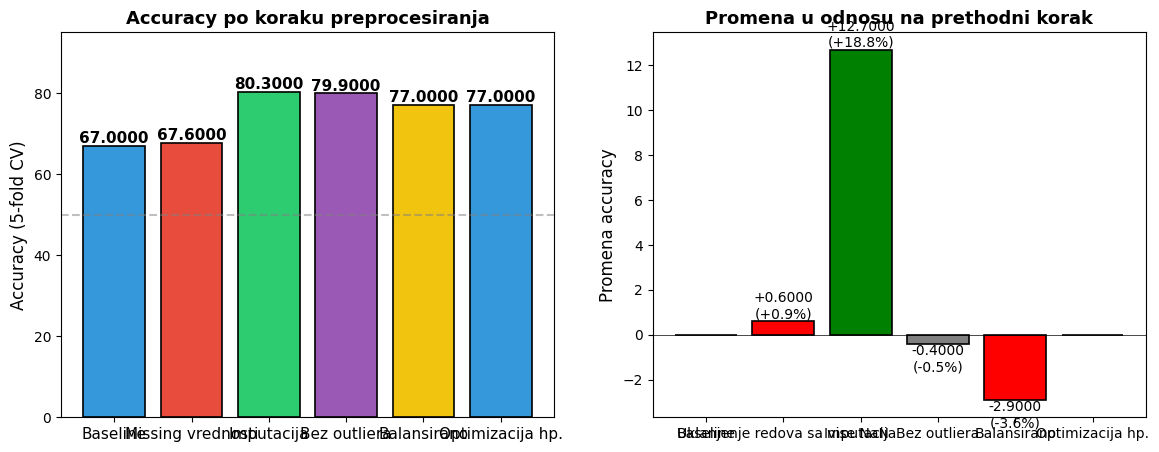

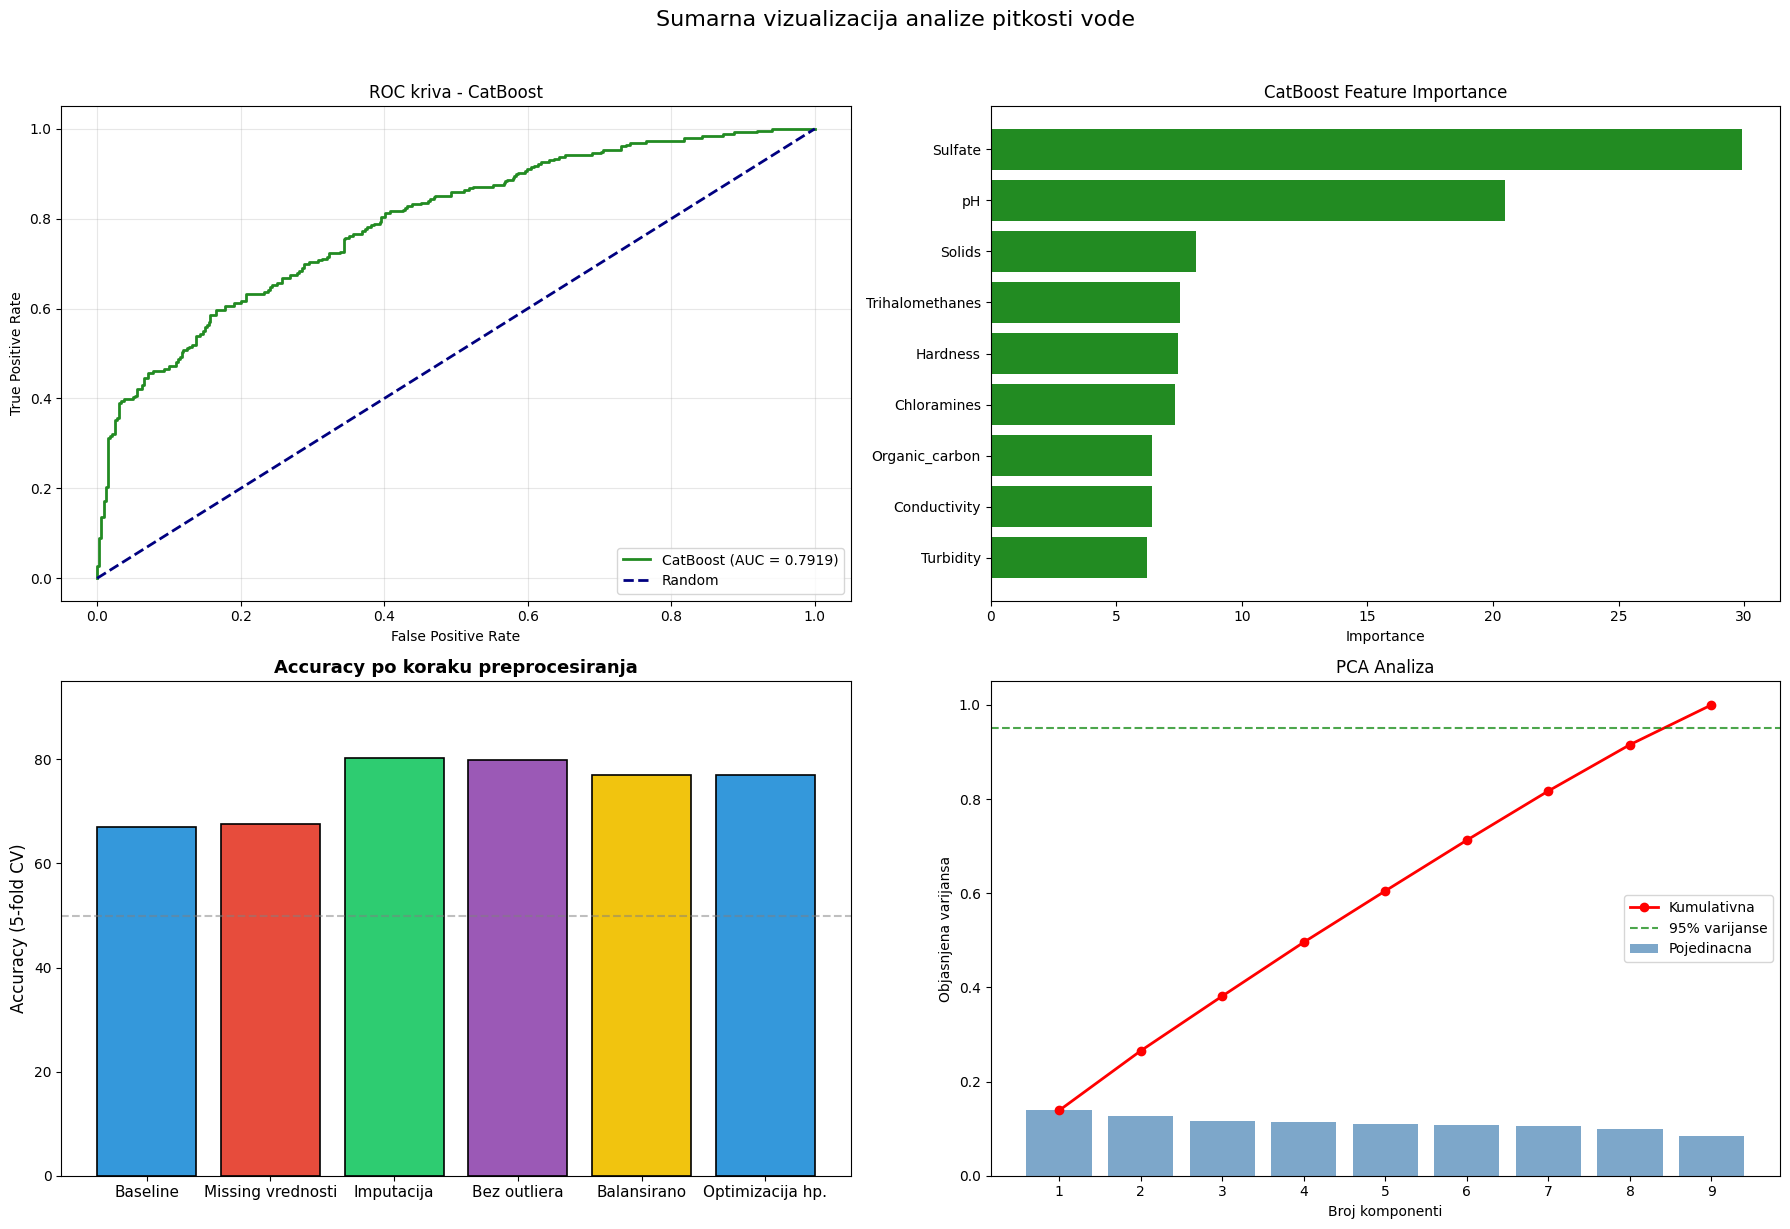

In [73]:
# Finalna vizualizacija - uporedni prikaz svih kljucnih metrika
fig = plt.figure(figsize=(18, 12))

# 1. ROC krivulja - CatBoost
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(fpr, tpr, color='forestgreen', lw=2, label=f'CatBoost (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC kriva - CatBoost')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# 2. Feature Importance
ax2 = fig.add_subplot(2, 2, 2)
fi_sorted = feature_importance.sort_values('importance', ascending=True)
ax2.barh(fi_sorted['feature'], fi_sorted['importance'], color='forestgreen')
ax2.set_xlabel('Importance')
ax2.set_title('CatBoost Feature Importance')

# 3. Accuracy po koracima preprocesiranja
ax3 = fig.add_subplot(2, 2, 3)
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f1c40f']
bars = ax3.bar(range(len(summary_df)), summary_df['Accuracy'], color=colors, edgecolor='black', linewidth=1.2)
ax3.set_xticks(range(len(summary_df)))
ax3.set_xticklabels(['Baseline', 'Missing vrednosti','Imputacija', 'Bez outliera', 'Balansirano', 'Optimizacija hp.'], fontsize=11)
ax3.set_ylabel('Accuracy (5-fold CV)', fontsize=12)
ax3.set_title('Accuracy po koraku preprocesiranja', fontsize=13, fontweight='bold')
ax3.set_ylim(0, 95)
ax3.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Random baseline')


# 4. PCA varijansa
ax4 = fig.add_subplot(2, 2, 4)
if 'pca_full' in dir():
    ax4.bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, alpha=0.7, color='steelblue', label='Pojedinacna')
    ax4.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
             'r-o', label='Kumulativna', linewidth=2)
    ax4.axhline(y=0.95, color='g', linestyle='--', label='95% varijanse', alpha=0.7)
    ax4.set_xlabel('Broj komponenti')
    ax4.set_ylabel('Objasnjena varijansa')
    ax4.set_title('PCA Analiza')
    ax4.legend()
    ax4.set_xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))
else:
    ax4.text(0.5, 0.5, 'PCA nije izvrsena', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('PCA Analiza')

plt.suptitle('Sumarna vizualizacija analize pitkosti vode', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()